In [2]:
import json
import os
import subprocess
import sys

from pathlib import Path
from IPython.display import display, display_pdf, Image
from IPython.display import IFrame
from PIL import Image as PImage

import sycamore
from sycamore.data import Document
from sycamore.transforms.embed import SentenceTransformerEmbedder
from sycamore.transforms.extract_entity import OpenAIEntityExtractor
from sycamore.llms import OpenAIModels, OpenAI, LLM
from sycamore.transforms.partition import SycamorePartitioner, ArynPartitioner
from sycamore.llms.prompts.default_prompts import TEXT_SUMMARIZER_GUIDANCE_PROMPT_CHAT
from sycamore.transforms.summarize import Summarizer
from sycamore.transforms.extract_table import CachedTextractTableExtractor, TextractTableExtractor
from sycamore.functions.document import split_and_convert_to_image, DrawBoxes
from sycamore.tests.config import TEST_DIR
from sycamore.transforms.merge_elements import GreedyTextElementMerger
from sycamore.functions.tokenizer import HuggingFaceTokenizer
from sycamore.connectors.file.file_scan import JsonManifestMetadataProvider

from sycamore.utils.pdf_utils import show_pages
import nltk

from ray.data import ActorPoolStrategy

The prompt TEXT_SUMMARIZER_GUIDANCE_PROMPT_CHAT is deprecated. Switch to TextSummarizerGuidancePrompt()


In [2]:
# %%bash
# mkdir -p visualize_pdfs
# curl https://investors.3m.com/financials/sec-filings/content/0001558370-19-000470/0001558370-19-000470.pdf -o visualize_pdfs/3m_1.pdf

In [3]:
if os.path.exists("/.dockerenv"):
    # Running in Docker.
    work_dir = "/visualize_pdfs"
else:
    # Running outside of docker. This will land under notebooks/data/
    work_dir = "./data"
work_dir = "/visualize_pdfs"

In [3]:
def partition_visualize(paths, tables, thrshld=0.3):
    if len(paths) == 0:
        print("WARNING: import_pdf called with empty paths")
    
    if (
        (isinstance(paths, str) or isinstance(paths, Path)) 
        and Path(paths).exists() and Path(paths).is_dir()
        and len(list(Path(paths).iterdir())) == 0
    ):
        print("WARNING: import_pdf called with empty directory")
    
    ctx = sycamore.init()
    pdf_docset = ctx.read.binary(paths, binary_format="pdf", filter_paths_by_extension=False)
    # tablex=CachedTextractTableExtractor(region_name="us-east-1", s3_cache_location="s3://aanya-textract/cache", s3_textract_upload_path="s3://aanya-textract/cache")
    # tablex=TextractTableExtractor(profile_name="AdministratorAccess-237550789389", region_name="us-east-1", s3_upload_root="s3://aanya-textract")
    partitioned_docset = pdf_docset.partition(partitioner=SycamorePartitioner(extract_table_structure=tables, threshold=thrshld, use_ocr=True), compute=ActorPoolStrategy(size=1))
    
    # show_pages(partitioned_docset, limit=1)
    # partitioned_docset.show(limit=1000000)
    return partitioned_docset.take_all()

In [3]:
from sycamore.llms.prompts.default_prompts import SimpleGuidancePrompt

openai_llm = OpenAI(OpenAIModels.GPT_3_5_TURBO_INSTRUCT.value, api_key="#")

class KeywordExtractorZeroShotGuidancePrompt(SimpleGuidancePrompt):
    system = "You are a helpful keyword extractor."
    user = """You are given a text representation of an element in a document. You need to extract up to 6 keywords from this text.
    Using the text representation from the document and the provided examples, FIND, COPY, and RETURN the keywords. Return only a series of 6 words/phrases separated by
    commas as your answer. DO NOT REPHRASE OR MAKE UP AN ANSWER. This is the text representation:
    {text}
    """

prompt = KeywordExtractorZeroShotGuidancePrompt()


In [12]:
def merge_kw_partitioned(partitioned):
    return partitioned.merge(merger=GreedyTextElementMerger(HuggingFaceTokenizer("sentence-transformers/all-mpnet-base-v2"), 512)).map_elements(keyword_enhance).take_all()

In [34]:
# def keyword_enhance(elem):
#     # llm call: give it a prompt, example, and text representation of element
#     # add the result of the llm call to the element under a new 'keyword' field
#     keywords = openai_llm.generate(
#         prompt_kwargs={
#             "prompt": prompt,
#             "text": elem.text_representation,
#         }
#     )
#     elem.properties.update({"keywords": keywords})
#     return elem

# Title page, 3M 10K
# doc_ocr_new = partition_visualize("/home/admin/sycamore/examples/visualize_pdfs/3m_table.pdf", True, 0.35)
# doc_ocr_new
doc_ocr_q3 = partition_visualize("/home/admin/sycamore/examples/visualize_pdfs/j_n_j_10k_cash_flow.pdf", True, 0.35)
doc_ocr_q3

2024-07-19 23:46:17,721	WARNING util.py:560 -- The argument ``compute`` is deprecated in Ray 2.9. Please specify argument ``concurrency`` instead. For more information, see https://docs.ray.io/en/master/data/transforming-data.html#stateful-transforms.
2024-07-19 23:46:17,726	INFO streaming_executor.py:112 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-07-19_20-40-11_772469_4094/logs/ray-data
2024-07-19 23:46:17,726	INFO streaming_executor.py:113 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadBinary] -> TaskPoolMapOperator[Map(BinaryScan._to_document)] -> ActorPoolMapOperator[MapBatches(BaseMapTransformCallable___wrap)]


- ReadBinary->SplitBlocks(16) 1:   0%|          | 0/1 [00:00<?, ?it/s]

- Map(BinaryScan._to_document) 2:   0%|          | 0/1 [00:00<?, ?it/s]

- MapBatches(BaseMapTransformCallable___wrap) 3:   0%|          | 0/1 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

[{'properties': {'path': '/home/admin/sycamore/examples/visualize_pdfs/j_n_j_10k_cash_flow.pdf', 'filetype': 'application/pdf'}, 'elements': [{'type': 'Section-header', 'bbox': (0.02839678596047794, 0.11832909323952415, 0.8607607134650735, 0.13629932750355114), 'properties': {'score': 0.6694893836975098, 'page_number': 1}, 'text_representation': 'Johnson & Johnson and subsidiaries consolidated statements of cash flows\n'}, {'type': 'table', 'bbox': (0.028259694716509652, 0.15868390170010654, 0.9590157542509191, 0.7482279274680398), 'properties': {'score': 0.9027976393699646, 'title': None, 'columns': None, 'rows': None, 'page_number': 1}, '_override_text': ',2023,2022,2021\nCash flows from operating activities,,,\nNet earnings,"S35,153","17,941","20,878"\nAdjustments to reconcile net earnings to cash flows operating activities: from,,,\nDepreciation and amortization of property and intangibles,"7,486","6,970","7,390"\nStock based compensation,"1,162","1,138","1,135"\nAsset write-downs,

In [35]:
doc_ocr_q3[0].elements

[{'type': 'Section-header', 'bbox': (0.02839678596047794, 0.11832909323952415, 0.8607607134650735, 0.13629932750355114), 'properties': {'score': 0.6694893836975098, 'page_number': 1}, 'text_representation': 'Johnson & Johnson and subsidiaries consolidated statements of cash flows\n'},
 {'type': 'table', 'bbox': (0.028259694716509652, 0.15868390170010654, 0.9590157542509191, 0.7482279274680398), 'properties': {'score': 0.9027976393699646, 'title': None, 'columns': None, 'rows': None, 'page_number': 1}, '_override_text': ',2023,2022,2021\nCash flows from operating activities,,,\nNet earnings,"S35,153","17,941","20,878"\nAdjustments to reconcile net earnings to cash flows operating activities: from,,,\nDepreciation and amortization of property and intangibles,"7,486","6,970","7,390"\nStock based compensation,"1,162","1,138","1,135"\nAsset write-downs,"1,295","1,216",989\nCharge for purchase of in-process research and development assets,483,,\nGain on Kenvue separation,"(20,984)",,\nNet ga

In [33]:
import pandas as pd
f = open("/home/admin/sycamore/examples/visualize_pdfs/test.csv", "w")
f.write(doc_ocr_q3[0].elements[3]['_override_text'])
df = pd.read_csv("/home/admin/sycamore/examples/visualize_pdfs/test.csv")
df

Unnamed: 0  \
0                                         Net revenue   
1                                       Cost of sales   
2                                        Gross margin   
3                            Research and development   
4               Marketing, general and administrative   
5        Restructuring and other special charges, net   
6                                      Licensing gain   
7                             Operating income (loss)   
8                                    Interest expense   
9                         Other income expense) , net   
10  Income (loss) before income taxes and equity loss   
11               Provision (benefit) for income taxes   
12                            Equity loss in investee   
13                                  Net income (loss)   
14                          Earnings (loss) per share   
15                                              Basic   
16                                            Diluted   
17               Shares used in per share calculation   
18                                              Basic   
19                                            Diluted   

   Year Ended | December 29 2018  \
0                          6,475   
1                          4,028   
2                          2,447   
3                          1,434   
4                            562   
5                            NaN   
6                            NaN   
7                            451   
8                          (121)   
9                            NaN   
10                           330   
11                           NaN   
12                           (2)   
13                           337   
14                           NaN   
15                          0.34   
16                          0.32   
17                           NaN   
18                           982   
19                         1.064   

   Year Ended | December 30, 2017 | (In millions except per share amounts)  \
0                                               5,253                        
1                                               3,466                        
2                                               1,787                        
3                                               1,196                        
4                                                 516                        
5                                                 NaN                        
6                                                 52)                        
7                                                 127                        
8                                                126)                        
9                                                 NaN                        
10                                                NaN                        
11                                                 18                        
12                                                NaN                        
13                                               (33)                        
14                                                NaN                        
15                                             (0.03)                        
16                                             (0.03)                        
17                                                NaN                        
18                                                952                        
19                                                952                        

   Year Ended | December 31_ 2016  
0                           4,319  
1                           3,316  
2                            ,003  
3                           1,008  
4                             466  
5                            (10)  
6                             88)  
7                            373)  
8                            156)  
9                              80  
10                          (449)  
11               

In [ ]:
doc_ocr_q3.elements

[{'type': 'Page-header', 'bbox': (0.03874198015998392, 0.026157691261985087, 0.1318423641429228, 0.03633919455788352), 'properties': {'score': 0.7613633275032043, 'page_number': 1}, 'text_representation': 'Table of Contents\n'},
 {'type': 'Section-header', 'bbox': (0.03878365460564109, 0.0711107704856179, 0.20858653349034925, 0.10243786898526279), 'properties': {'score': 0.6944294571876526, 'page_number': 1}, 'text_representation': '3M Company and Subsidiaries\nConsolidated Balance Sheet\nAt December 31\n'},
 {'type': 'Text', 'bbox': (0.03983590069939109, 0.8428731467507102, 0.5533212459788603, 0.8526483154296876), 'properties': {'score': 0.8432533740997314, 'page_number': 1}, 'text_representation': 'The accompanying Notes to Consolidated Financial Statements are an integral part of this statement.\n'},
 {'type': 'Page-footer', 'bbox': (0.4740212833180147, 0.888125887784091, 0.4871502326516544, 0.8981732177734375), 'properties': {'score': 0.9035388231277466, 'page_number': 1}, 'text_re

[{'type': 'Page-header', 'bbox': (0.09255656522863051, 0.026073728041215376, 0.1852215576171875, 0.03642521598122336), 'properties': {'score': 0.6304644346237183, 'page_number': 1}, 'text_representation': ''},
 {'type': 'Section-header', 'bbox': (0.09267366297104779, 0.06775324041193181, 0.26141276640050554, 0.07739688526500355), 'properties': {'score': 0.4514368176460266, 'page_number': 1}, 'text_representation': '3M Company and Subsidiaries\n'},
 {'type': 'Section-header', 'bbox': (0.09256969676298253, 0.07876385775479404, 0.24878978056066176, 0.08892682162198154), 'properties': {'score': 0.39440035820007324, 'page_number': 1}, 'text_representation': 'Consolidated Balance Sheet\n'},
 {'type': 'Section-header', 'bbox': (0.093045654296875, 0.09001419067382813, 0.18038742963005513, 0.100035400390625), 'properties': {'score': 0.4151681065559387, 'page_number': 1}, 'text_representation': 'At December 31\n'},
 {'type': 'table', 'bbox': (0.09022909725413603, 0.11174663890491833, 0.890631462

In [34]:
import pandas

f = open("/home/admin/sycamore/examples/fb-results/temp.csv", "a")
f.write(doc_ocr_q3[0].elements[4].text_representation)
f.close()

df = pandas.read_csv("/home/admin/sycamore/examples/fb-results/temp.csv")
df

3M Company and Subsidiaries Consolidated Balance Sheet At December 31  \
0                                                    0                      
1                                                    1                      
2                                                    2                      
3                                                    3                      
4                                                    4                      
..                                                 ...                      
102                                                 49                      
103  The accompanying Notes to Consolidated Financi...                      
104                                                 50                      
105                                                 50                      
106                                                 50                      

                                                   0          1          2  
0    (Dollars in millions, except per share amount)       2022       2021   
1                                            Assets         NaN        NaN  
2                                    Current assets         NaN        NaN  
3                         Cash and cash equivalents    $ 3,655    $ 4,564   
4                   Marketable securities - current        238        201   
..                                               ...        ...        ...  
102                    Total liabilities and equity   $ 46,455   $ 47,072   
103                                              NaN        NaN        NaN  
104                                              NaN        NaN        NaN  
105                                              NaN        NaN        NaN  
106                                              NaN        NaN        NaN  

[107 rows x 4 columns]

In [59]:
df.iloc[4,3]

'201 '

In [69]:
rows = df.iloc[1:,1].tolist()
cols = df.iloc[0, 2:].tolist()

sentences = []
for i in range(len(rows)):
    for j in range(len(cols)):
        if "nan" not in [str(rows[i]), str(cols[j]), str(df.iloc[1+i,2+j])]:
            sentences.append(str(rows[i]) + " in " + str(cols[j]) + " is " + str(df.iloc[1+i,2+j]))

sentences

$ 3,655 
$ 4,564 
238 
201 
4,532 
4,660 
2,497 
2,196 
1,606 
1,577 
1,269 
1,212 
5,372 
4,985 
435 
654 
456 
339 
14,688 
15,403 
25,998 
27,213 
(16,820) 
(17,784) 
9,178 
9,429 
829 
858 
12,790 
13,486 
4,699 
5,288 
4,271 
2,608 
$ 46,455 
$ 47,072 
$ 1,938 
$ 1,307 
3,183 
2,994 
692 
1,020 
259 
260 
261 
263 
3,190 
3,191 
9,523 
9,035 
14,001 
16,056 
1,966 
2,870 
580 
591 
5,615 
3,403 
31,685 
31,955 
9 
9 
6,691 
6,429 
47,950 
45,821 
(33,255) 
(30,463) 
(6,673) 
(6,750) 
14,722 
15,046 
48 
71 
14,770 
15,117 
$ 46,455 
$ 47,072 
1
2
2022 
2021 
$ 3,655 
$ 4,564 
238 
201 
4,532 
4,660 
2,497 
2,196 
1,606 
1,577 
1,269 
1,212 
5,372 
4,985 
435 
654 
456 
339 
14,688 
15,403 
25,998 
27,213 
(16,820) 
(17,784) 
9,178 
9,429 
829 
858 
12,790 
13,486 
4,699 
5,288 
4,271 
2,608 
$ 46,455 
$ 47,072 
$ 1,938 
$ 1,307 
3,183 
2,994 
692 
1,020 
259 
260 
261 
263 
3,190 
3,191 
9,523 
9,035 
14,001 
16,056 
1,966 
2,870 
580 
591 
5,615 
3,403 
31,685 
31,955 
9 
9 
6,69

['Cash and cash equivalents  in 2022  is $ 3,655 ',
 'Cash and cash equivalents  in 2021  is $ 4,564 ',
 'Marketable securities - current  in 2022  is 238 ',
 'Marketable securities - current  in 2021  is 201 ',
 'Accounts receivable - net of allowances of$174 and $189  in 2022  is 4,532 ',
 'Accounts receivable - net of allowances of$174 and $189  in 2021  is 4,660 ',
 'Finished goods  in 2022  is 2,497 ',
 'Finished goods  in 2021  is 2,196 ',
 'Work in process  in 2022  is 1,606 ',
 'Work in process  in 2021  is 1,577 ',
 'Raw materials and supplies  in 2022  is 1,269 ',
 'Raw materials and supplies  in 2021  is 1,212 ',
 'Total inventories  in 2022  is 5,372 ',
 'Total inventories  in 2021  is 4,985 ',
 'Prepaids  in 2022  is 435 ',
 'Prepaids  in 2021  is 654 ',
 'Other current assets  in 2022  is 456 ',
 'Other current assets  in 2021  is 339 ',
 'Total current assets  in 2022  is 14,688 ',
 'Total current assets  in 2021  is 15,403 ',
 'Property, plant and equipment  in 2022  is

In [7]:
f2 = open("/home/admin/sycamore/examples/fb-results/temp2.csv", "a")
f2.write(doc_ocr_q3[0].elements[4].text_representation)
f2.close()

df2 = pandas.read_csv("/home/admin/sycamore/examples/fb-results/temp2.csv")
df2

50
0  50

In [4]:
import boto3
s3 = boto3.client("s3")
cache_id = self._cache_id(s3, document.properties["path"])

In [5]:
s3

In [7]:
for i in doc_ocr_q3[0].elements:
    print (i)

{'type': 'Page-header', 'bbox': (0.03804574405445772, 0.03275755101984197, 0.13242854398839615, 0.042726835771040486), 'properties': {'score': 0.7435891628265381, 'page_number': 1}, 'text_representation': 'Table of Contents\n'}
{'type': 'Title', 'bbox': (0.27432864918428307, 0.09026356090198864, 0.7262573960248162, 0.12526263150301847), 'properties': {'score': 0.6969747543334961, 'page_number': 1}}
{'type': 'Text', 'bbox': (0.42836264217601105, 0.12667584505948154, 0.5731679041245404, 0.1369879843971946), 'properties': {'score': 0.49102556705474854, 'page_number': 1}}
{'type': 'Title', 'bbox': (0.4423318301930147, 0.14452975186434658, 0.5599818330652574, 0.1616406943581321), 'properties': {'score': 0.7233740091323853, 'page_number': 1}}
{'type': 'Text', 'bbox': (0.4948068775850184, 0.1851410466974432, 0.5074977740119485, 0.19462050004438922), 'properties': {'score': 0.39353206753730774, 'page_number': 1}, 'text_representation': 'or\n'}
{'type': 'Text', 'bbox': (0.037335992700913374, 0.

In [4]:
for i in doc1[0].elements:
    if i.type == 'table':
        print (i)

NameError: name 'doc1' is not defined

In [21]:
for i in doc2[0].elements:
    if i.type == 'table':
        print (i.table.to_csv())

(Millions),2018,2017,2016
Cash Flows Operating Activities from,,,
"Net income including noncontrolling interest 5,363 4.869 5,058",,,
Adjustments to reconcile net income including noncontrolling interest to net cash provided by operating activities,,,
Depreciation and amortization,"1,488","1,544","1,474"
Company pension and postretirement contributions,(370),967),(383)
Company pension and postretirement expense,410,334,250
Stock-based compensation expense,302,324,298
Gain on sale of businesses,(545),(586),(111)
Deferred income taxes,(57),107,
Changes in assets and liabilities,,,
Accounts receivable,(305),(245),(313)
Inventories,(509),(387),57
Accounts payable,408,24,148
Accrued income taxes current and term) long-',134,967,101
Other net,120,256,76
Net cash provided by (used in) operating activities,"6,439","6,240",66_
Cash Flows from Investing Activities,,,
"Purchases of property, plant and equipment (PP&E)","(1,577)","(1,373)","1,420)"
Proceeds from sale of PP&E and other assets,262,4

In [4]:
def is_consolidated(elements, table_idx):
    prev = range(table_idx-5, table_idx) if table_idx > 5 else range(table_idx)
    for j in prev:
        if (elements[j].text_representation is not None) and ("Consolidated" in elements[j].text_representation):
            return True

def ocr_table(table):
    pass

In [5]:
elems = doc[0].elements
for i in range(len(elems)):
    if elems[i].type == 'table':
        if is_consolidated(elems, i):
            pass

In [6]:
from sycamore.data.element import TableElement


# print (isinstance(doc[0].elements[3], TableElement))
# print (doc[0].elements[3])
doc

[{'properties': {'path': '/home/admin/sycamore/examples/visualize_pdfs/3m_1.pdf', 'filetype': 'application/pdf'}, 'elements': [{'type': 'Page-header', 'bbox': (0.09254883710075827, 0.02588048761541193, 0.18516457950367646, 0.036462620821866125), 'properties': {'score': 0.7105238437652588, 'page_number': 1}, 'text_representation': ''}, {'type': 'Section-header', 'bbox': (0.0923248291015625, 0.0672761327570135, 0.3043683220358456, 0.09994891079989347), 'properties': {'score': 0.4793054163455963, 'page_number': 1}, 'text_representation': '3M Company and Subsidiaries\nConsolidated Statement of Cash Flows\nYears ended December 31\n'}, {'type': 'Section-header', 'bbox': (0.09287836411420036, 0.0673000127618963, 0.2605581844554228, 0.07790306784889915), 'properties': {'score': 0.3135610818862915, 'page_number': 1}, 'text_representation': '3M Company and Subsidiaries\n'}, {'type': 'table', 'bbox': (0.0904532668169807, 0.11156481656161221, 0.8908106186810661, 0.6249001242897727), 'properties': 

In [4]:
# Activision Blizzard
doc = partition_visualize("home/admin/sycamore/examples/visualize_pdfs/actbl_1.pdf", True, 0.35)
doc

FileNotFoundError: home/admin/sycamore/examples/visualize_pdfs/actbl_1.pdf

In [8]:
# for doc in docs[0].elements:
#     if doc.type == 'table':
#         table = doc.table

# table.cells

2024-07-10 22:26:52,235	WARNING util.py:560 -- The argument ``compute`` is deprecated in Ray 2.9. Please specify argument ``concurrency`` instead. For more information, see https://docs.ray.io/en/master/data/transforming-data.html#stateful-transforms.
2024-07-10 22:26:52,240	INFO streaming_executor.py:112 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-07-10_22-25-44_664218_148065/logs/ray-data
2024-07-10 22:26:52,241	INFO streaming_executor.py:113 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadBinary] -> TaskPoolMapOperator[Map(BinaryScan._to_document)] -> ActorPoolMapOperator[MapBatches(BaseMapTransformCallable___wrap)] -> TaskPoolMapOperator[MapBatches(split_and_convert_to_image)] -> LimitOperator[limit=1] -> TaskPoolMapOperator[MapBatches(DrawBoxes)]


- ReadBinary->SplitBlocks(16) 1:   0%|          | 0/1 [00:00<?, ?it/s]

- Map(BinaryScan._to_document) 2:   0%|          | 0/1 [00:00<?, ?it/s]

- MapBatches(BaseMapTransformCallable___wrap) 3:   0%|          | 0/1 [00:00<?, ?it/s]

- MapBatches(split_and_convert_to_image) 4:   0%|          | 0/1 [00:00<?, ?it/s]

- limit=1 5:   0%|          | 0/1 [00:00<?, ?it/s]

- MapBatches(DrawBoxes) 6:   0%|          | 0/1 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

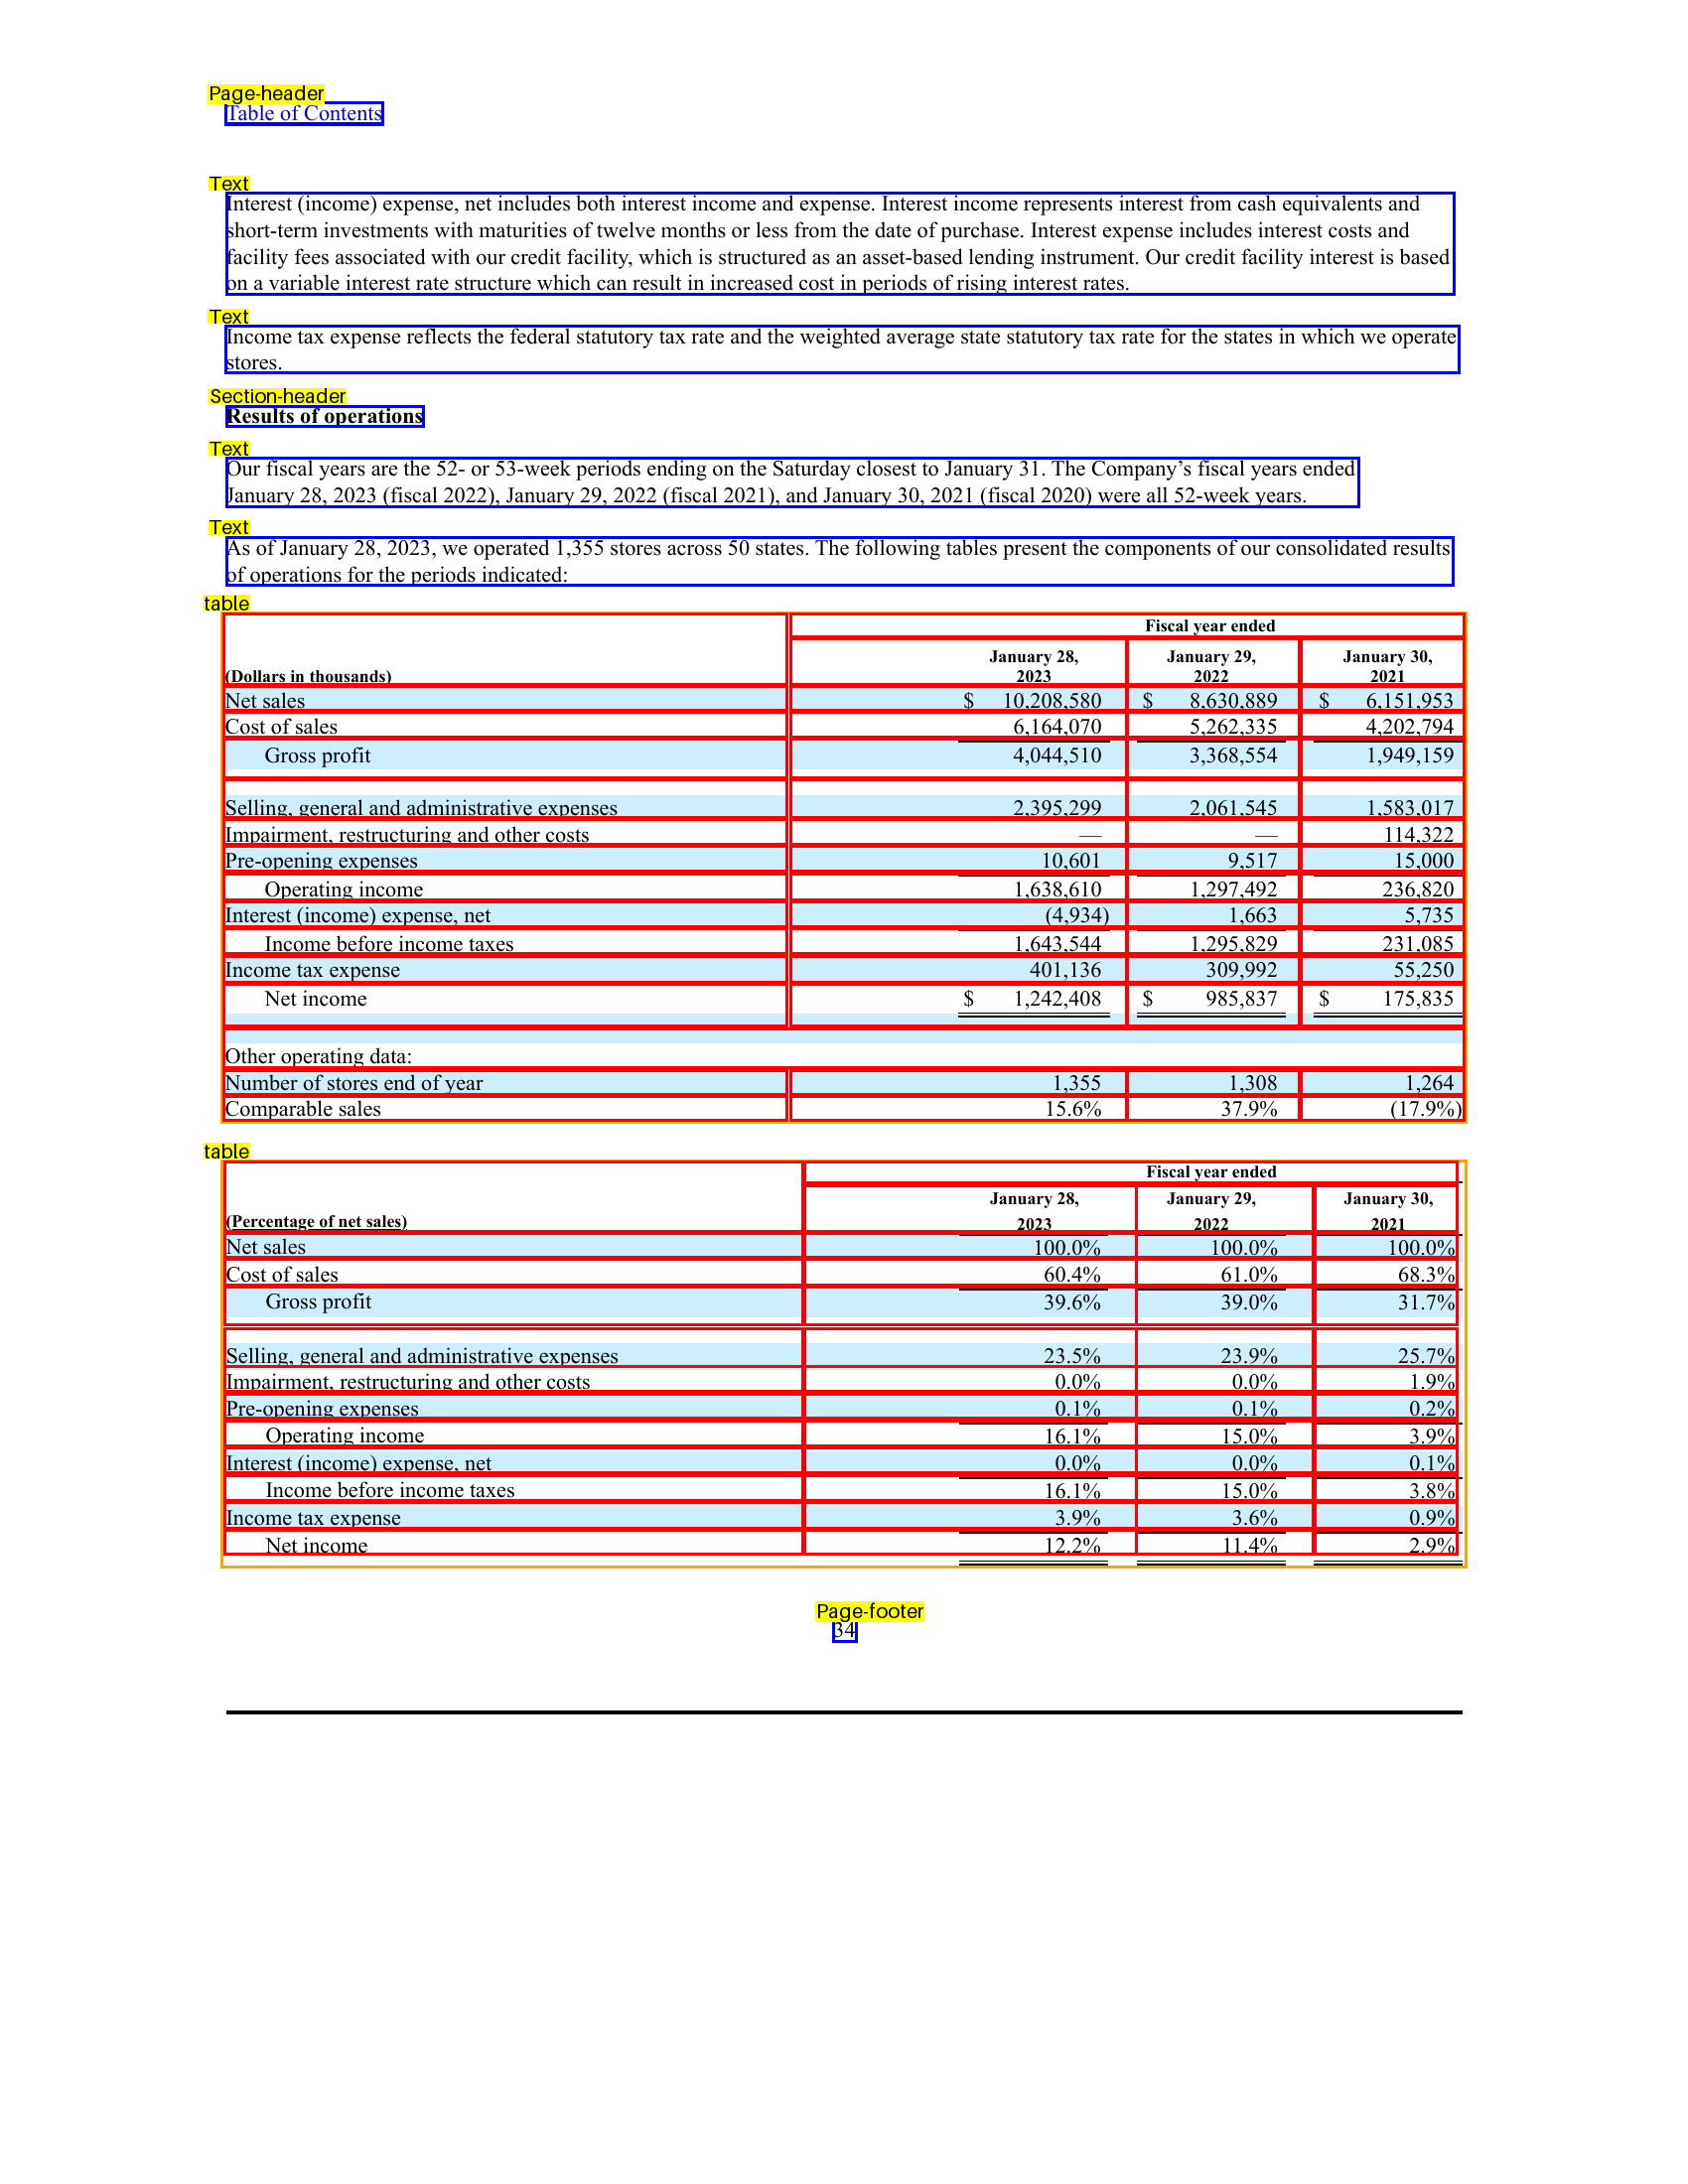

2024-07-10 22:27:06,342	WARNING util.py:560 -- The argument ``compute`` is deprecated in Ray 2.9. Please specify argument ``concurrency`` instead. For more information, see https://docs.ray.io/en/master/data/transforming-data.html#stateful-transforms.
2024-07-10 22:27:06,347	INFO streaming_executor.py:112 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-07-10_22-25-44_664218_148065/logs/ray-data
2024-07-10 22:27:06,347	INFO streaming_executor.py:113 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadBinary] -> TaskPoolMapOperator[Map(BinaryScan._to_document)] -> ActorPoolMapOperator[MapBatches(BaseMapTransformCallable___wrap)]


- ReadBinary->SplitBlocks(16) 1:   0%|          | 0/1 [00:00<?, ?it/s]

- Map(BinaryScan._to_document) 2:   0%|          | 0/1 [00:00<?, ?it/s]

- MapBatches(BaseMapTransformCallable___wrap) 3:   0%|          | 0/1 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

[{'properties': {'path': '/home/admin/sycamore/examples/visualize_pdfs/ultabeauty_table.pdf', 'filetype': 'application/pdf'}, 'elements': [{'type': 'Page-header', 'bbox': (0.13335161994485295, 0.046735957752574574, 0.22736624325022978, 0.057378411726518114), 'properties': {'score': 0.653598427772522, 'page_number': 1}, 'text_representation': ''}, {'type': 'Text', 'bbox': (0.13375696518841912, 0.08800819396972656, 0.8618204273897059, 0.13503834117542612), 'properties': {'score': 0.9231100082397461, 'page_number': 1}, 'text_representation': 'Interest (income) expense, net includes both interest income and expense. Interest income represents interest from cash equivalents and\nshort-term investments with maturities of twelve months or less from the date of purchase. Interest expense includes interest costs and\nfacility fees associated with our credit facility, which is structured as an asset-based lending instrument. Our credit facility interest is based\non a variable interest rate stru

In [9]:
# ulta beauty table
partition_visualize("/home/admin/sycamore/examples/visualize_pdfs/ultabeauty_table.pdf", True, 0.35)

ERROR:root:Unable to load aryn config /home/admin/.aryn/config.yaml: [Errno 2] No such file or directory: '/home/admin/.aryn/config.yaml'
2024-07-09 21:16:32,081	WARNING util.py:560 -- The argument ``compute`` is deprecated in Ray 2.9. Please specify argument ``concurrency`` instead. For more information, see https://docs.ray.io/en/master/data/transforming-data.html#stateful-transforms.
2024-07-09 21:16:32,086	INFO streaming_executor.py:112 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-07-09_16-32-36_503269_2681/logs/ray-data
2024-07-09 21:16:32,087	INFO streaming_executor.py:113 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadBinary] -> TaskPoolMapOperator[Map(BinaryScan._to_document)] -> ActorPoolMapOperator[MapBatches(BaseMapTransformCallable___wrap)] -> TaskPoolMapOperator[MapBatches(split_and_convert_to_image)] -> LimitOperator[limit=1] -> TaskPoolMapOperator[MapBatches(DrawBoxes)]


- ReadBinary->SplitBlocks(16) 1:   0%|          | 0/1 [00:00<?, ?it/s]

- Map(BinaryScan._to_document) 2:   0%|          | 0/1 [00:00<?, ?it/s]

- MapBatches(BaseMapTransformCallable___wrap) 3:   0%|          | 0/1 [00:00<?, ?it/s]

- MapBatches(split_and_convert_to_image) 4:   0%|          | 0/1 [00:00<?, ?it/s]

- limit=1 5:   0%|          | 0/1 [00:00<?, ?it/s]

- MapBatches(DrawBoxes) 6:   0%|          | 0/1 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

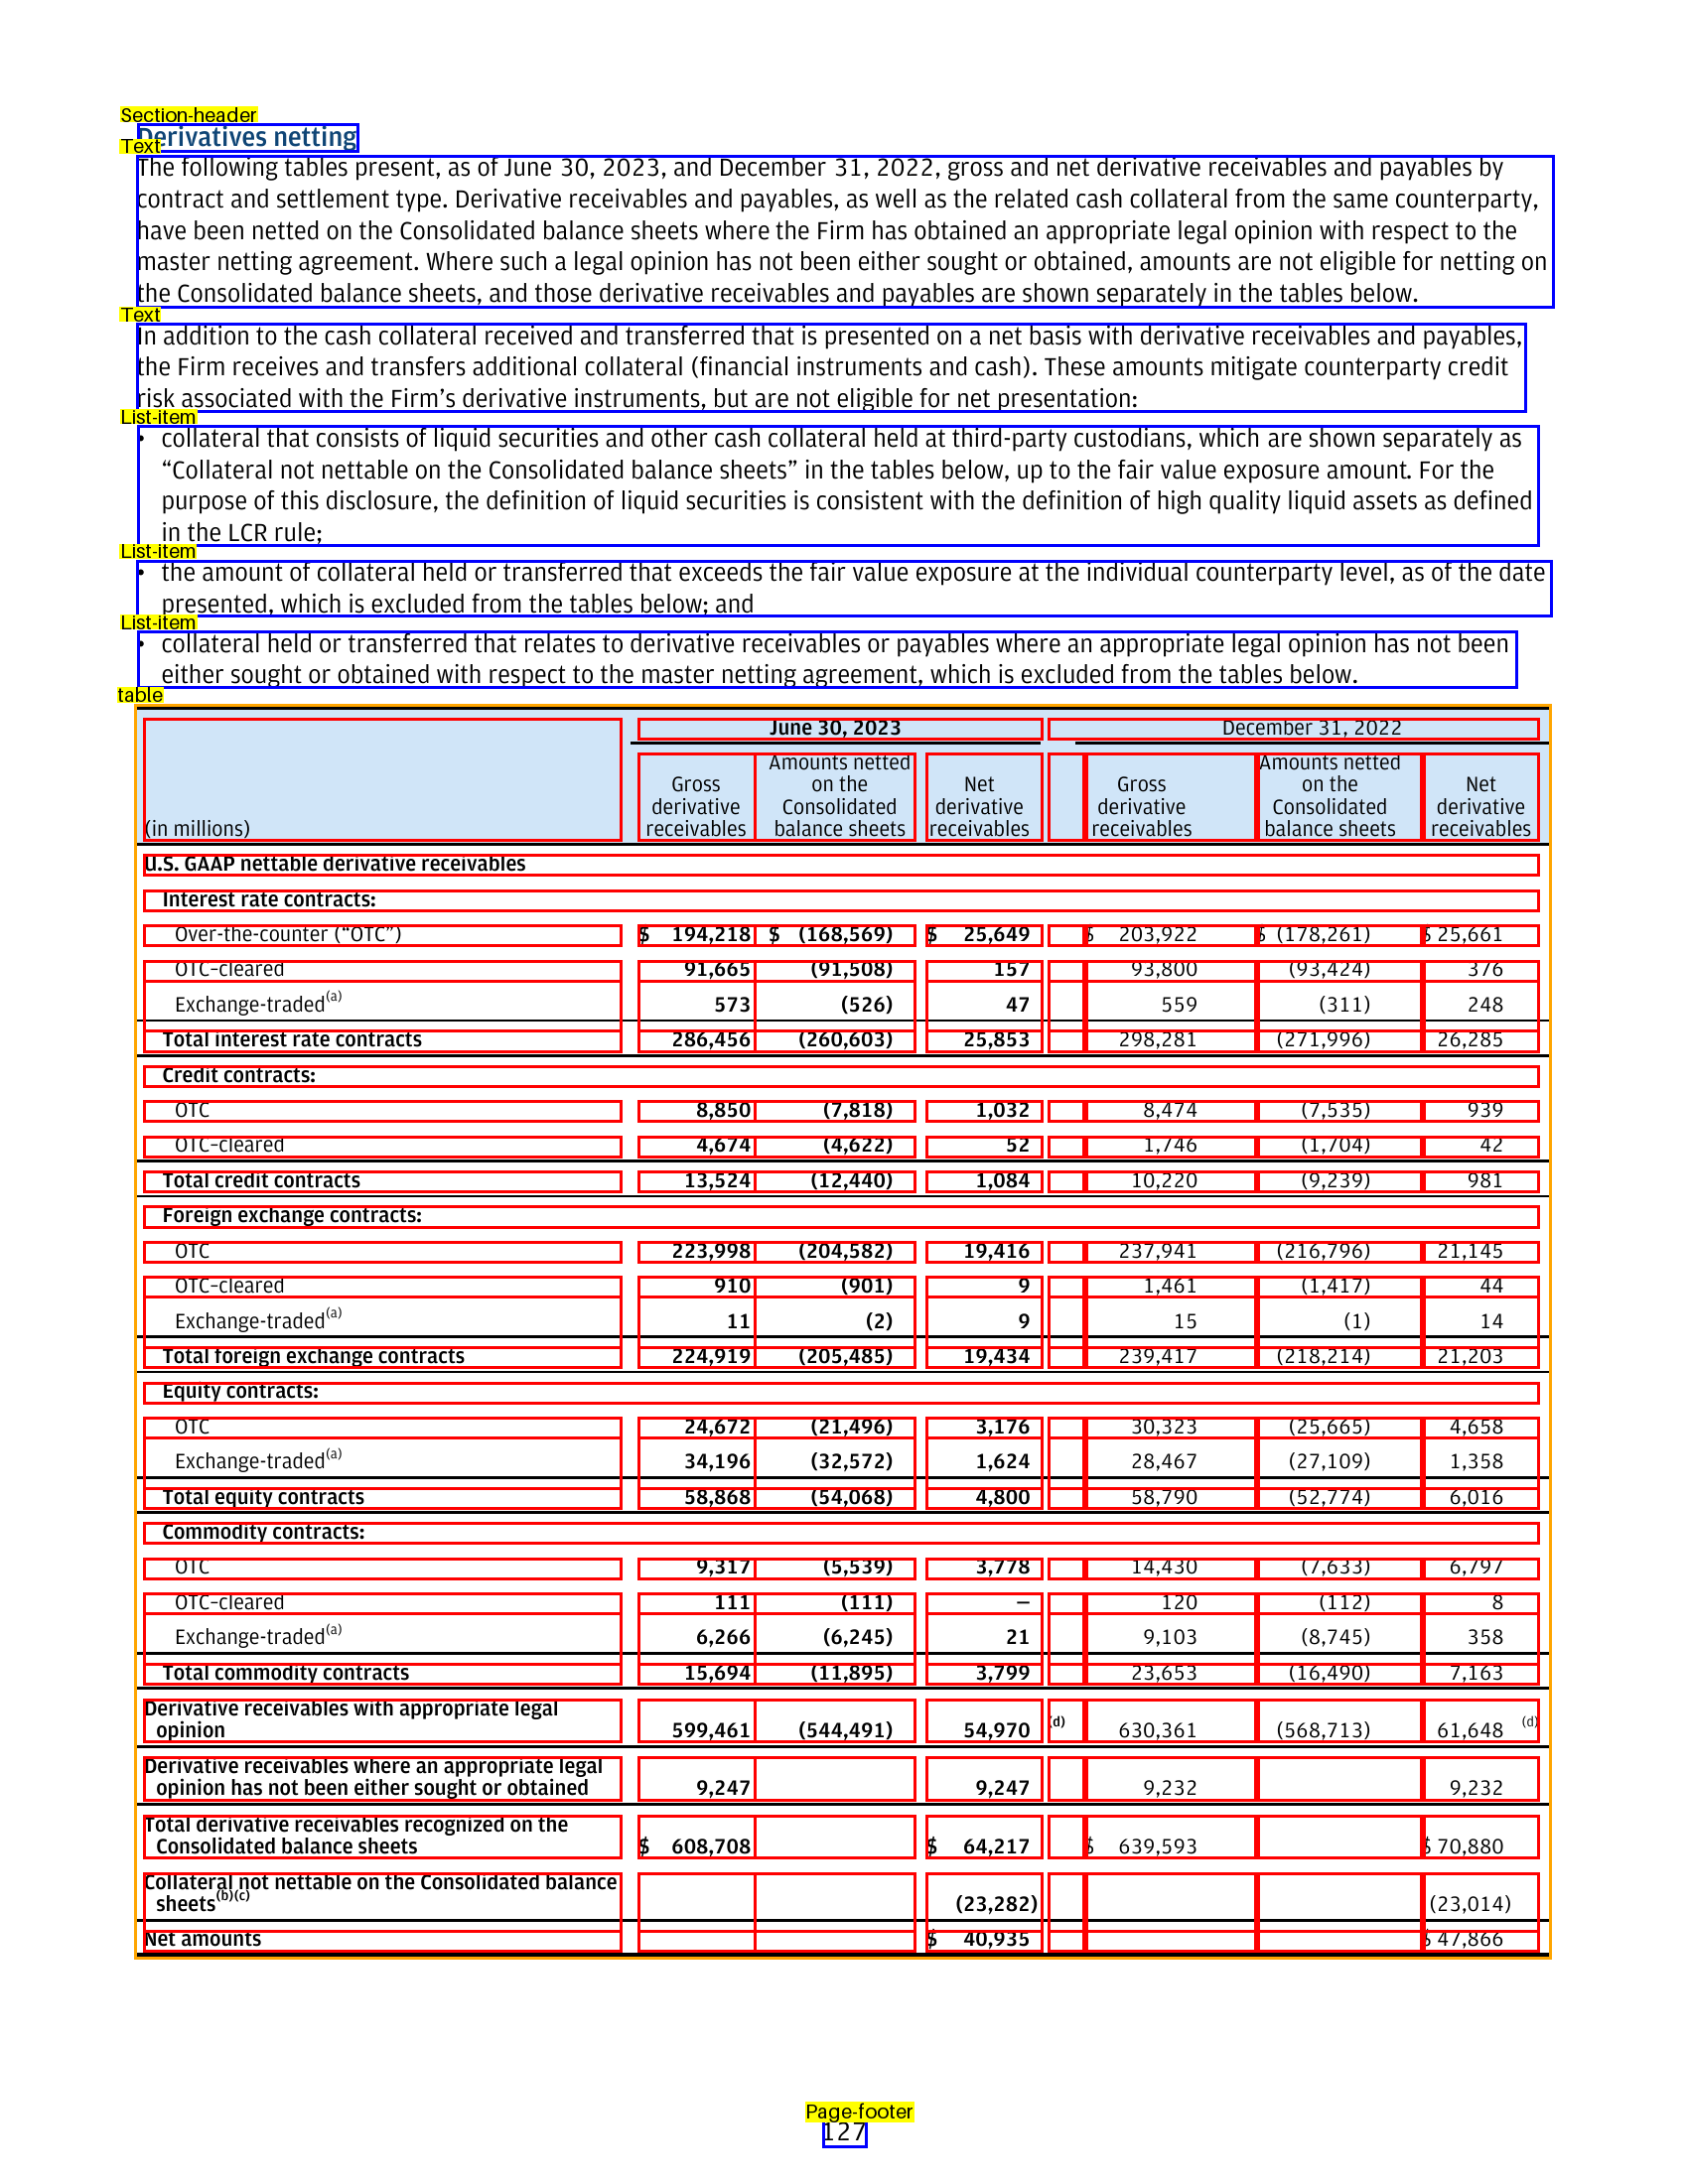

2024-07-09 21:16:39,598	WARNING util.py:560 -- The argument ``compute`` is deprecated in Ray 2.9. Please specify argument ``concurrency`` instead. For more information, see https://docs.ray.io/en/master/data/transforming-data.html#stateful-transforms.
2024-07-09 21:16:39,602	INFO streaming_executor.py:112 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-07-09_16-32-36_503269_2681/logs/ray-data
2024-07-09 21:16:39,602	INFO streaming_executor.py:113 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadBinary] -> TaskPoolMapOperator[Map(BinaryScan._to_document)] -> ActorPoolMapOperator[MapBatches(BaseMapTransformCallable___wrap)]


- ReadBinary->SplitBlocks(16) 1:   0%|          | 0/1 [00:00<?, ?it/s]

- Map(BinaryScan._to_document) 2:   0%|          | 0/1 [00:00<?, ?it/s]

- MapBatches(BaseMapTransformCallable___wrap) 3:   0%|          | 0/1 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

{'properties': {'path': '/home/admin/sycamore/examples/visualize_pdfs/JPM_table.pdf',
                'filetype': 'application/pdf'},
 'elements': [{'type': 'Section-header',
               'bbox': (0.08126772712258731,
                        0.05678133184259588,
                        0.2124626787971048,
                        0.06968645962801846),
               'properties': {'score': 0.840736985206604, 'page_number': 1}},
              {'type': 'Text',
               'bbox': (0.08114484001608456,
                        0.07111093000932173,
                        0.9206279440487133,
                        0.140936279296875),
               'properties': {'score': 0.9211127758026123, 'page_number': 1},
               'text_representation': '9TaXePcXeTb(cid:1)(cid:64)TccX(cid:64)V\n'
                                      'N(cid:63)Y(cid:1)Zc(cid:67)(cid:67)ck(cid:64)b(cid:62)(cid:1 '
                                      '<1819 chars>'},
              {'type': 'Text',
          

KeyboardInterrupt: 

In [ ]:
# jpm table
partition_visualize("/home/admin/sycamore/examples/visualize_pdfs/JPM_table.pdf", True, 0.35)

ERROR:root:Unable to load aryn config /home/admin/.aryn/config.yaml: [Errno 2] No such file or directory: '/home/admin/.aryn/config.yaml'
2024-07-09 21:08:10,708	WARNING util.py:560 -- The argument ``compute`` is deprecated in Ray 2.9. Please specify argument ``concurrency`` instead. For more information, see https://docs.ray.io/en/master/data/transforming-data.html#stateful-transforms.
2024-07-09 21:08:10,713	INFO streaming_executor.py:112 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-07-09_16-32-36_503269_2681/logs/ray-data
2024-07-09 21:08:10,713	INFO streaming_executor.py:113 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadBinary] -> TaskPoolMapOperator[Map(BinaryScan._to_document)] -> ActorPoolMapOperator[MapBatches(BaseMapTransformCallable___wrap)] -> TaskPoolMapOperator[MapBatches(split_and_convert_to_image)] -> LimitOperator[limit=1] -> TaskPoolMapOperator[MapBatches(DrawBoxes)]


- ReadBinary->SplitBlocks(16) 1:   0%|          | 0/1 [00:00<?, ?it/s]

- Map(BinaryScan._to_document) 2:   0%|          | 0/1 [00:00<?, ?it/s]

- MapBatches(BaseMapTransformCallable___wrap) 3:   0%|          | 0/1 [00:00<?, ?it/s]

- MapBatches(split_and_convert_to_image) 4:   0%|          | 0/1 [00:00<?, ?it/s]

- limit=1 5:   0%|          | 0/1 [00:00<?, ?it/s]

- MapBatches(DrawBoxes) 6:   0%|          | 0/1 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

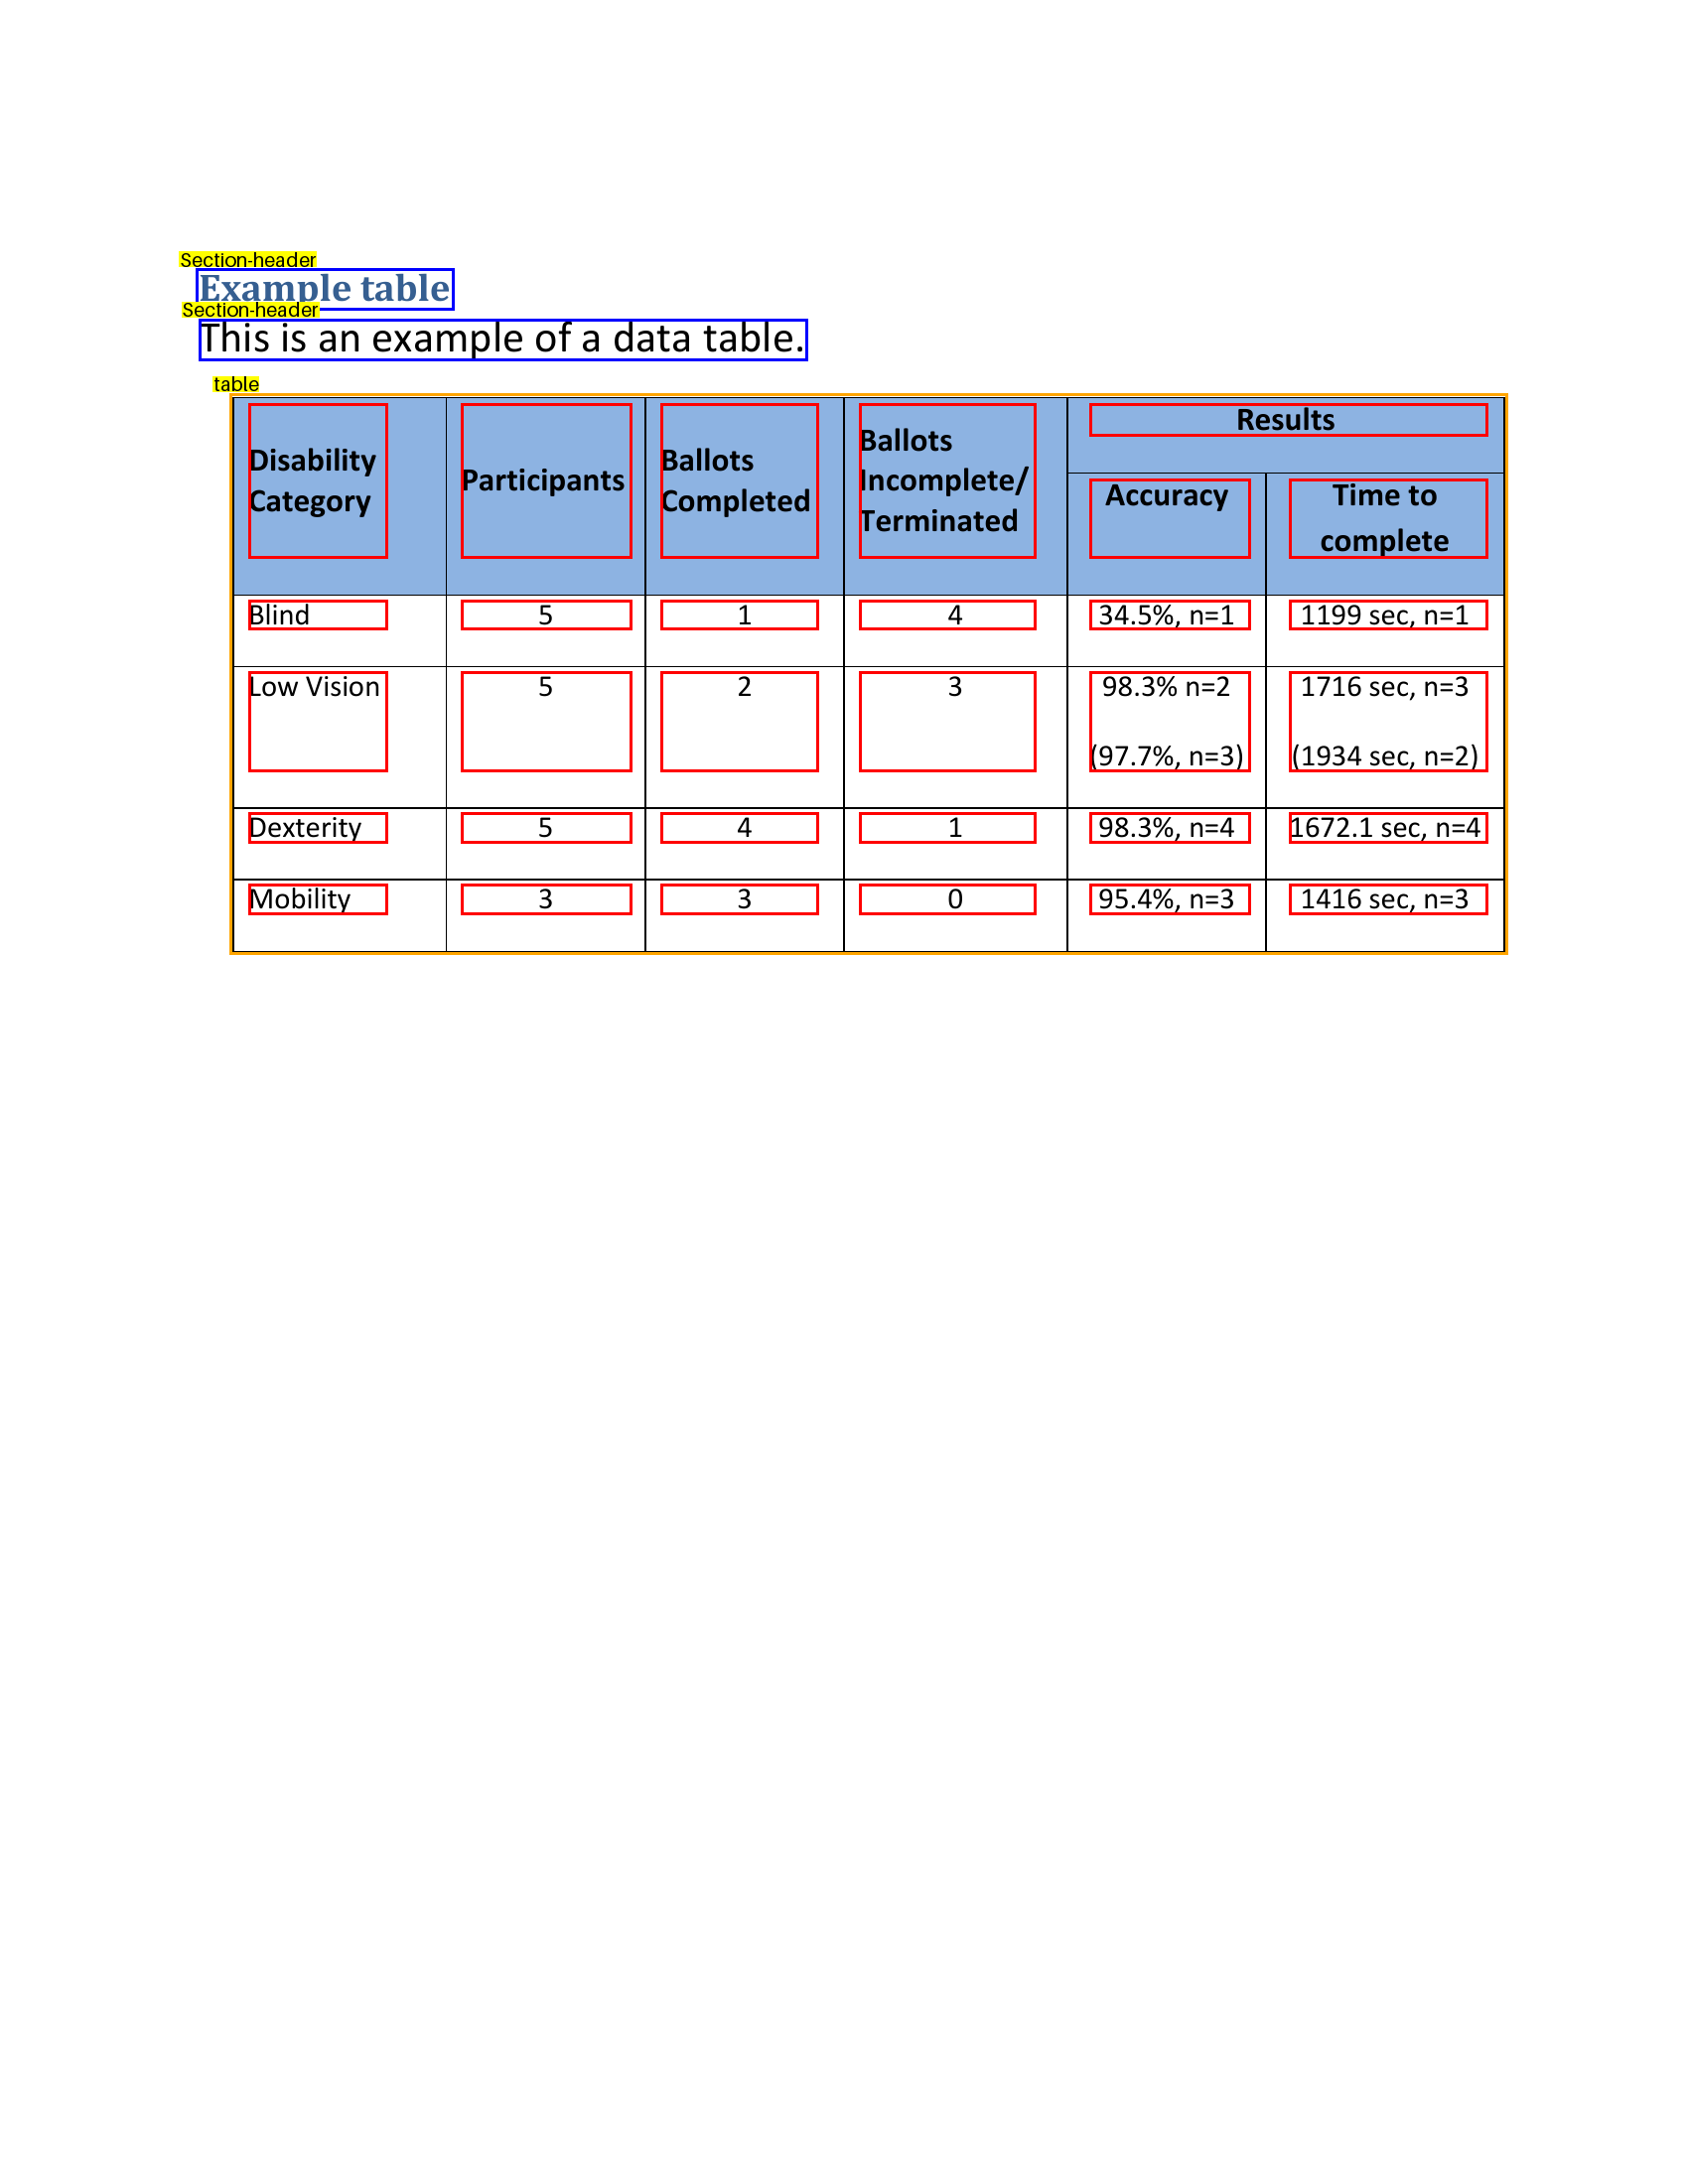

In [ ]:
# Page with table, 3M 10K
partition_visualize("/home/admin/sycamore/examples/visualize_pdfs/table-2.pdf", True, 0.35)

2024-06-12 19:33:38,625	INFO streaming_executor.py:115 -- Starting execution of Dataset. Full log is in /tmp/ray/session_2024-06-12_16-21-46_510622_17252/logs/ray-data.log
2024-06-12 19:33:38,625	INFO streaming_executor.py:116 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadBinary] -> TaskPoolMapOperator[Map(BinaryScan._to_document)->MapBatches(_wrap)->MapBatches(split_and_convert_to_image)] -> LimitOperator[limit=1] -> TaskPoolMapOperator[MapBatches(DrawBoxes)] -> LimitOperator[limit=1]



- ReadBinary->SplitBlocks(20) 1:   0%|          | 0/1 [00:00<?, ?it/s]

- Map(BinaryScan._to_document)->MapBatches(_wrap)->MapBatches(split_and_convert_to_image) 2:   0%|          | …

- limit=1 3:   0%|          | 0/1 [00:00<?, ?it/s]

- MapBatches(DrawBoxes) 4:   0%|          | 0/1 [00:00<?, ?it/s]

- limit=1 5:   0%|          | 0/1 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

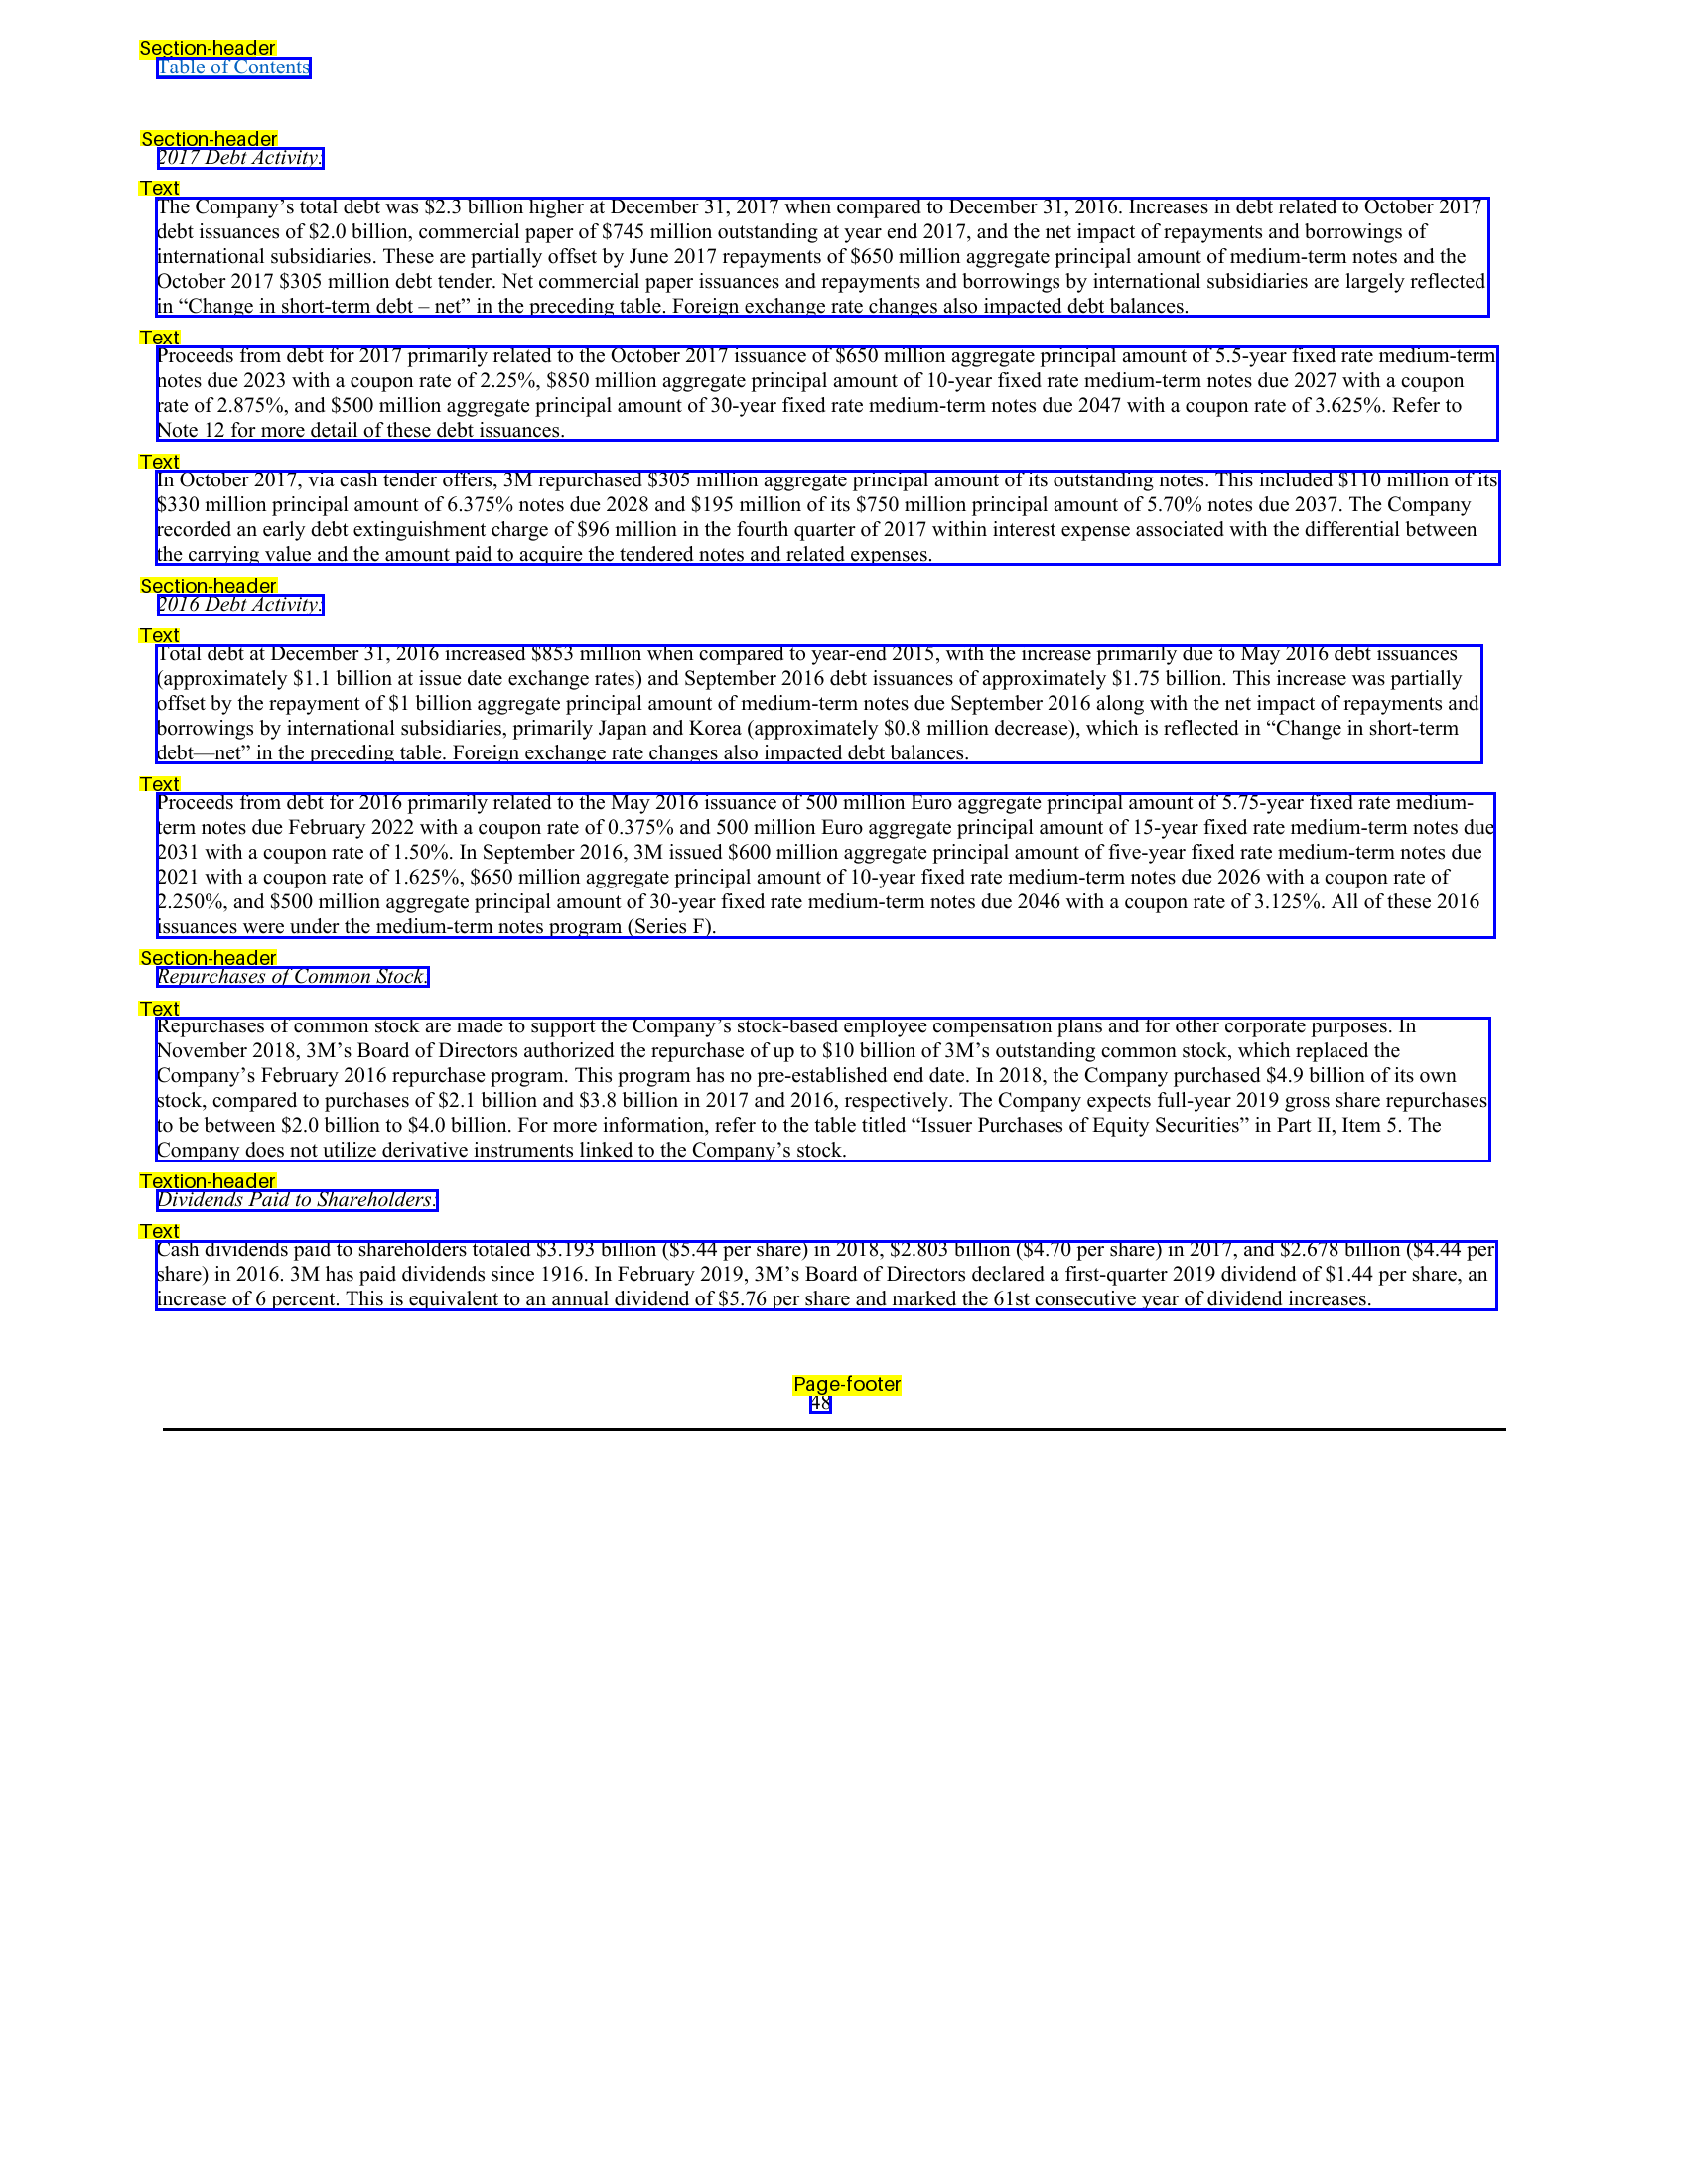

In [ ]:
# Page with text, 3M 10K
partition_visualize("/app/work/docker_volume/visualize_pdfs/3m_text.pdf", False, 0.3)

2024-06-12 19:34:03,515	INFO streaming_executor.py:115 -- Starting execution of Dataset. Full log is in /tmp/ray/session_2024-06-12_16-21-46_510622_17252/logs/ray-data.log
2024-06-12 19:34:03,516	INFO streaming_executor.py:116 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadBinary] -> TaskPoolMapOperator[Map(BinaryScan._to_document)->MapBatches(_wrap)->MapBatches(split_and_convert_to_image)] -> LimitOperator[limit=1] -> TaskPoolMapOperator[MapBatches(DrawBoxes)] -> LimitOperator[limit=1]



- ReadBinary->SplitBlocks(20) 1:   0%|          | 0/1 [00:00<?, ?it/s]

- Map(BinaryScan._to_document)->MapBatches(_wrap)->MapBatches(split_and_convert_to_image) 2:   0%|          | …

- limit=1 3:   0%|          | 0/1 [00:00<?, ?it/s]

- MapBatches(DrawBoxes) 4:   0%|          | 0/1 [00:00<?, ?it/s]

- limit=1 5:   0%|          | 0/1 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

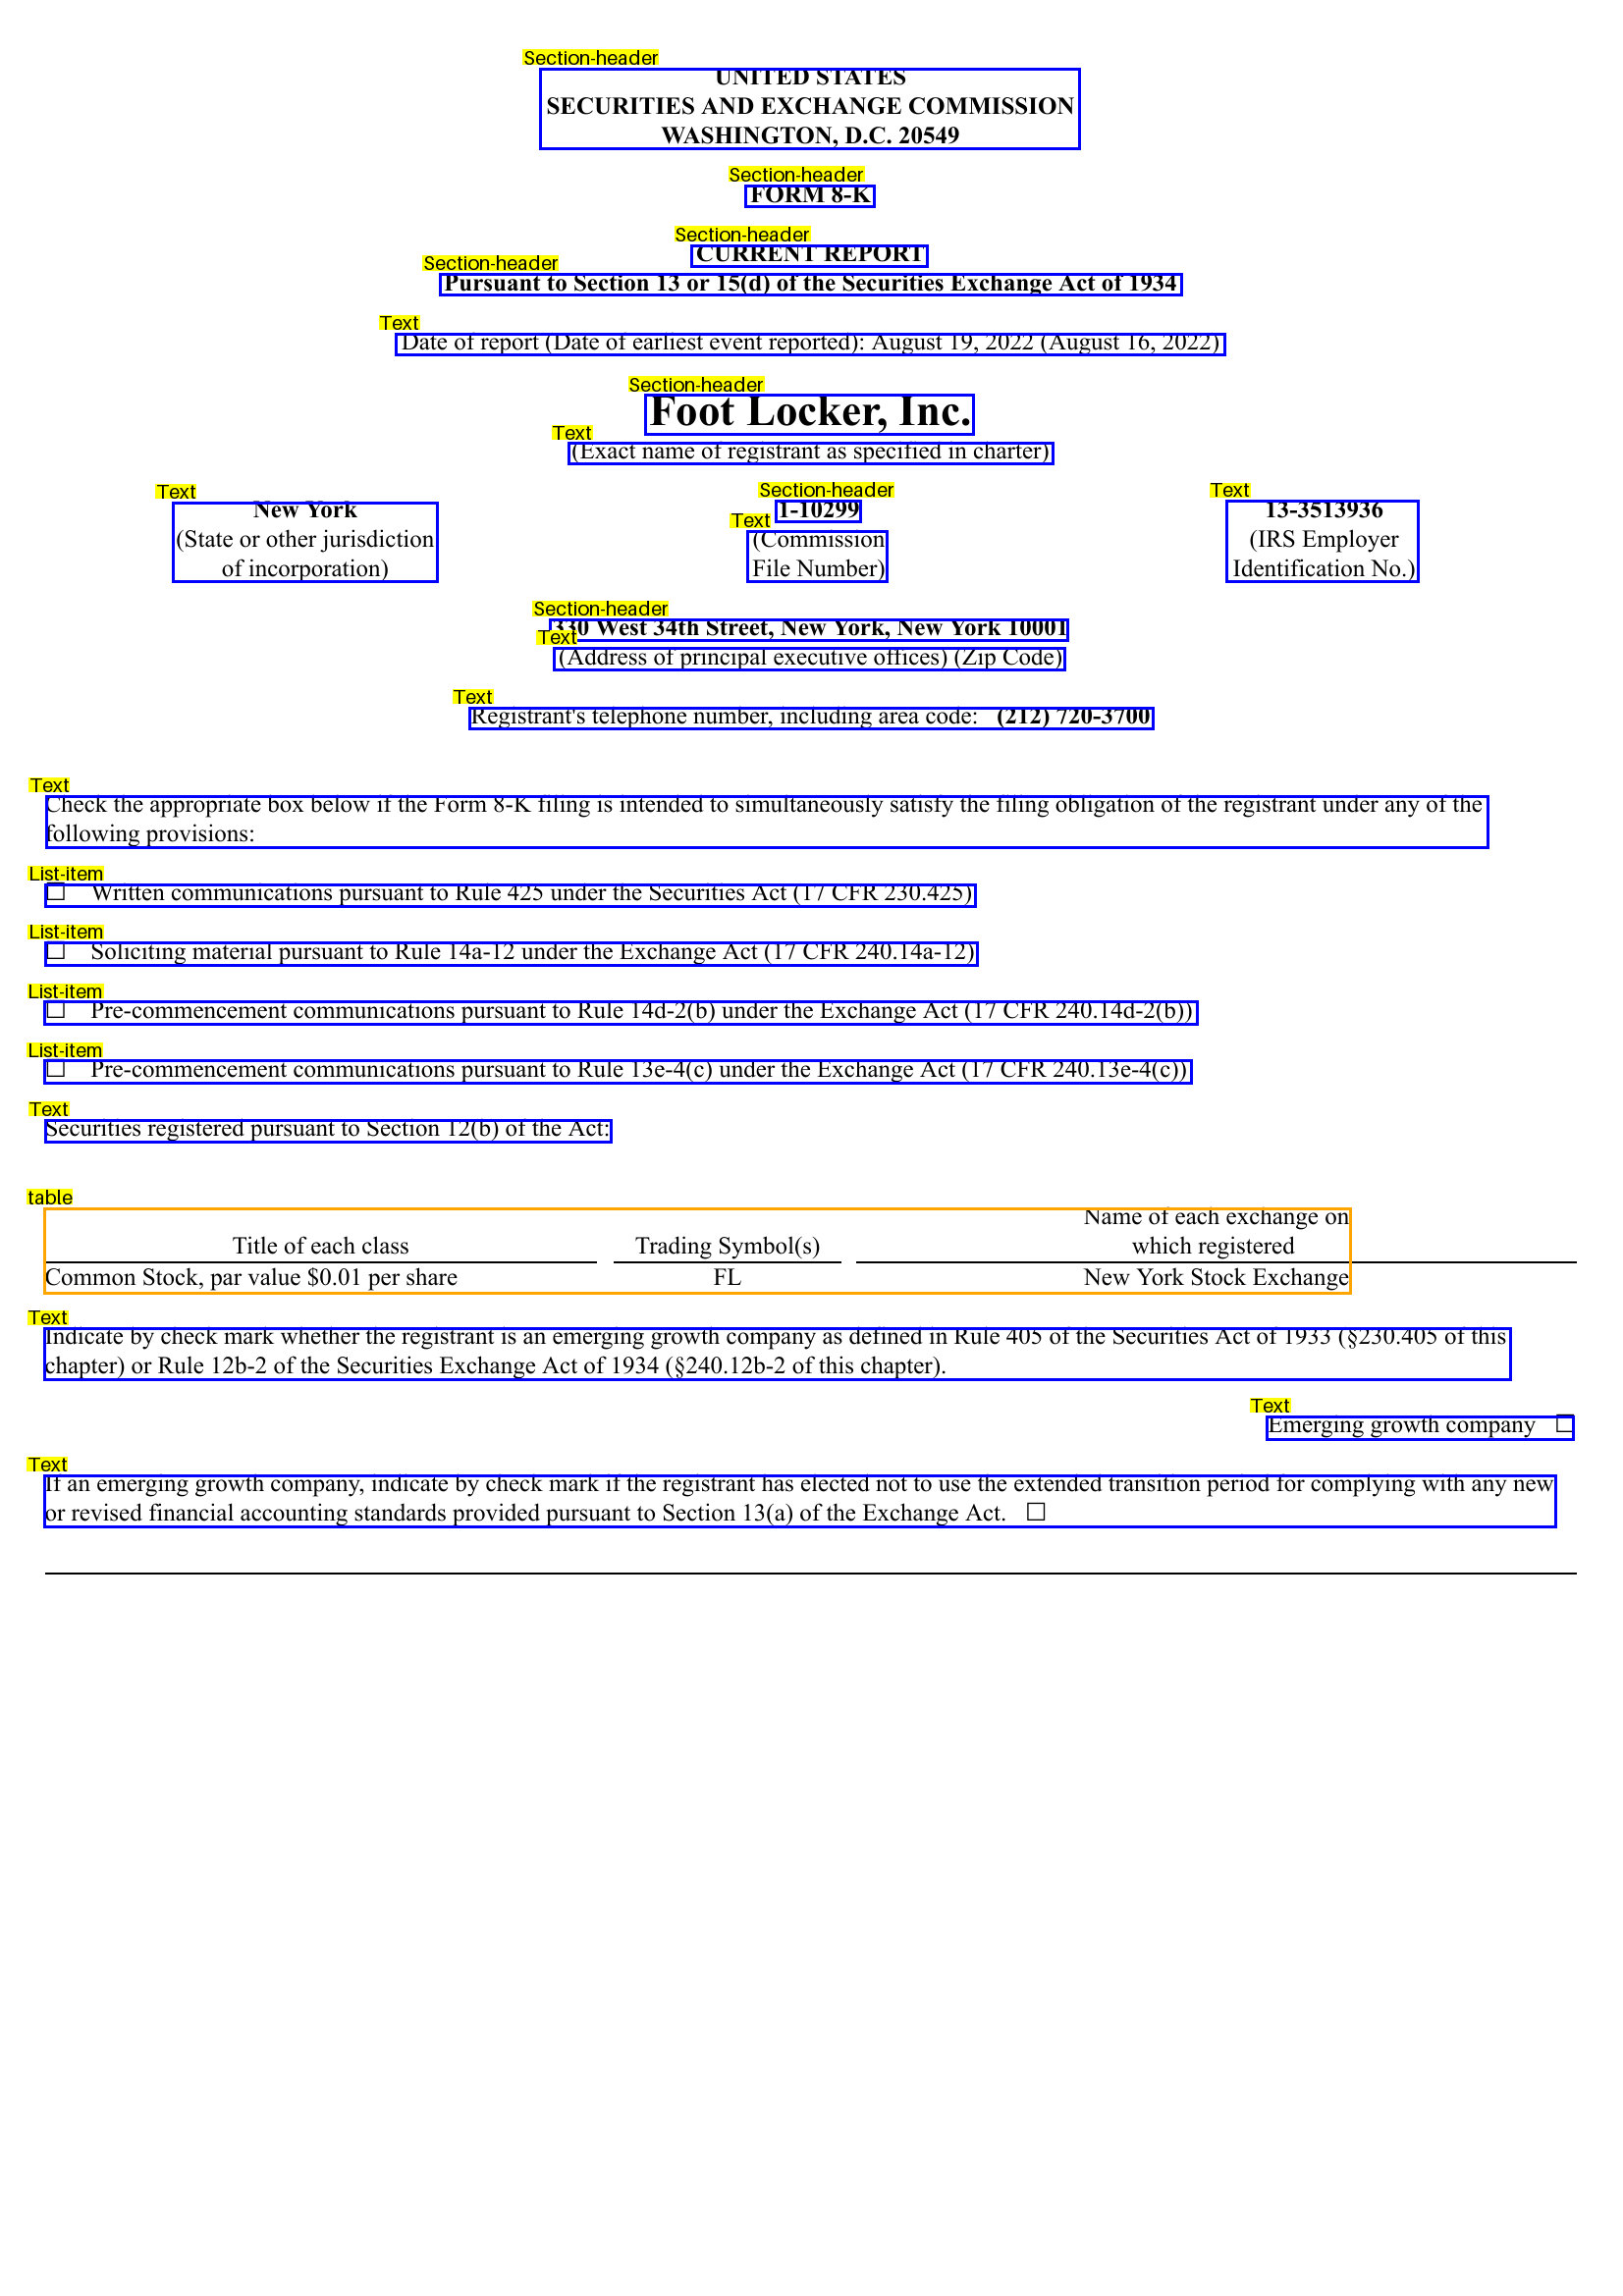

In [ ]:
# Title page, Foot Locker 8K
partition_visualize("/app/work/docker_volume/visualize_pdfs/footlocker_title.pdf", False, 0.35)

2024-06-12 19:34:26,106	INFO streaming_executor.py:115 -- Starting execution of Dataset. Full log is in /tmp/ray/session_2024-06-12_16-21-46_510622_17252/logs/ray-data.log
2024-06-12 19:34:26,107	INFO streaming_executor.py:116 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadBinary] -> TaskPoolMapOperator[Map(BinaryScan._to_document)->MapBatches(_wrap)->MapBatches(split_and_convert_to_image)] -> LimitOperator[limit=1] -> TaskPoolMapOperator[MapBatches(DrawBoxes)] -> LimitOperator[limit=1]



- ReadBinary->SplitBlocks(20) 1:   0%|          | 0/1 [00:00<?, ?it/s]

- Map(BinaryScan._to_document)->MapBatches(_wrap)->MapBatches(split_and_convert_to_image) 2:   0%|          | …

- limit=1 3:   0%|          | 0/1 [00:00<?, ?it/s]

- MapBatches(DrawBoxes) 4:   0%|          | 0/1 [00:00<?, ?it/s]

- limit=1 5:   0%|          | 0/1 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

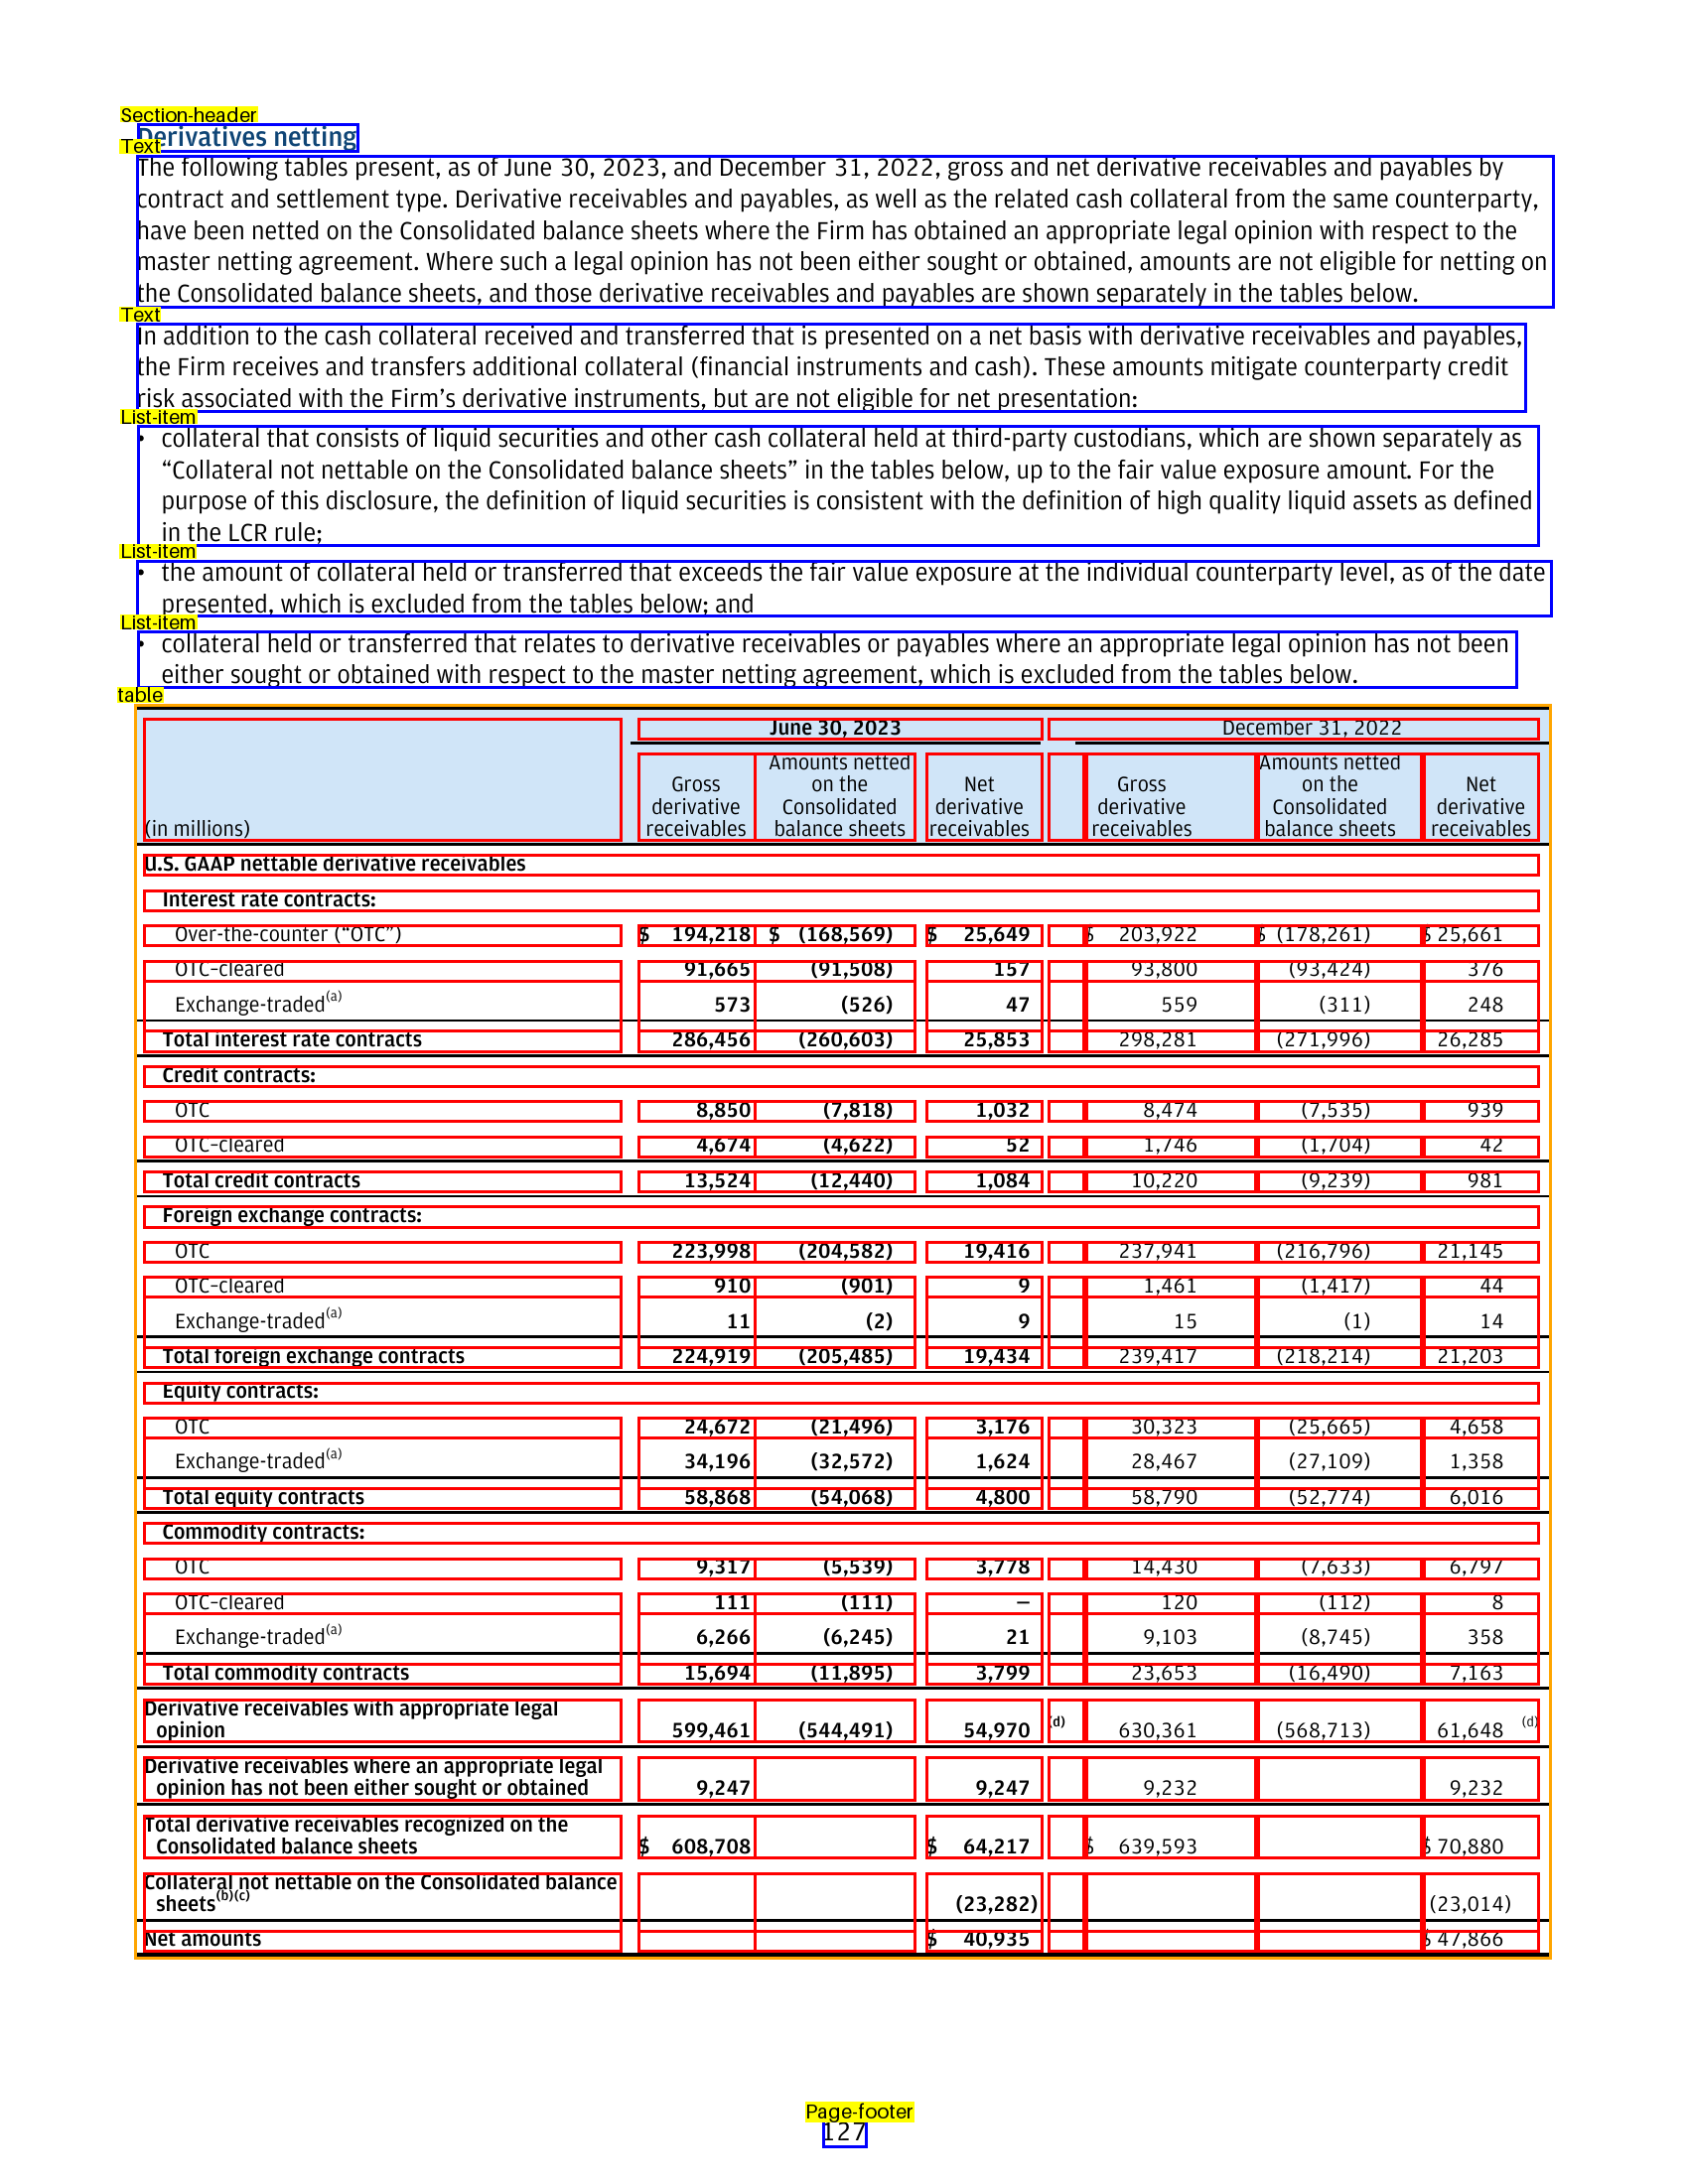

In [ ]:
# Page with table, JP Morgan 10Q
partition_visualize("/app/work/docker_volume/visualize_pdfs/JPM_table.pdf", True, 0.35)

2024-06-12 19:55:10,150	WARNING util.py:561 -- The argument ``compute`` is deprecated in Ray 2.9. Please specify argument ``concurrency`` instead. For more information, see https://docs.ray.io/en/master/data/transforming-data.html#stateful-transforms.
2024-06-12 19:55:10,162	INFO streaming_executor.py:115 -- Starting execution of Dataset. Full log is in /tmp/ray/session_2024-06-12_16-21-46_510622_17252/logs/ray-data.log
2024-06-12 19:55:10,163	INFO streaming_executor.py:116 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadBinary] -> ActorPoolMapOperator[Map(BinaryScan._to_document)->MapBatches(BaseMapTransformCallable___wrap)] -> TaskPoolMapOperator[MapBatches(split_and_convert_to_image)] -> LimitOperator[limit=1] -> TaskPoolMapOperator[MapBatches(DrawBoxes)] -> LimitOperator[limit=1]



- ReadBinary->SplitBlocks(20) 1:   0%|          | 0/1 [00:00<?, ?it/s]

- Map(BinaryScan._to_document)->MapBatches(BaseMapTransformCallable___wrap) 2:   0%|          | 0/1 [00:00<?, …

- MapBatches(split_and_convert_to_image) 3:   0%|          | 0/1 [00:00<?, ?it/s]

- limit=1 4:   0%|          | 0/1 [00:00<?, ?it/s]

- MapBatches(DrawBoxes) 5:   0%|          | 0/1 [00:00<?, ?it/s]

- limit=1 6:   0%|          | 0/1 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

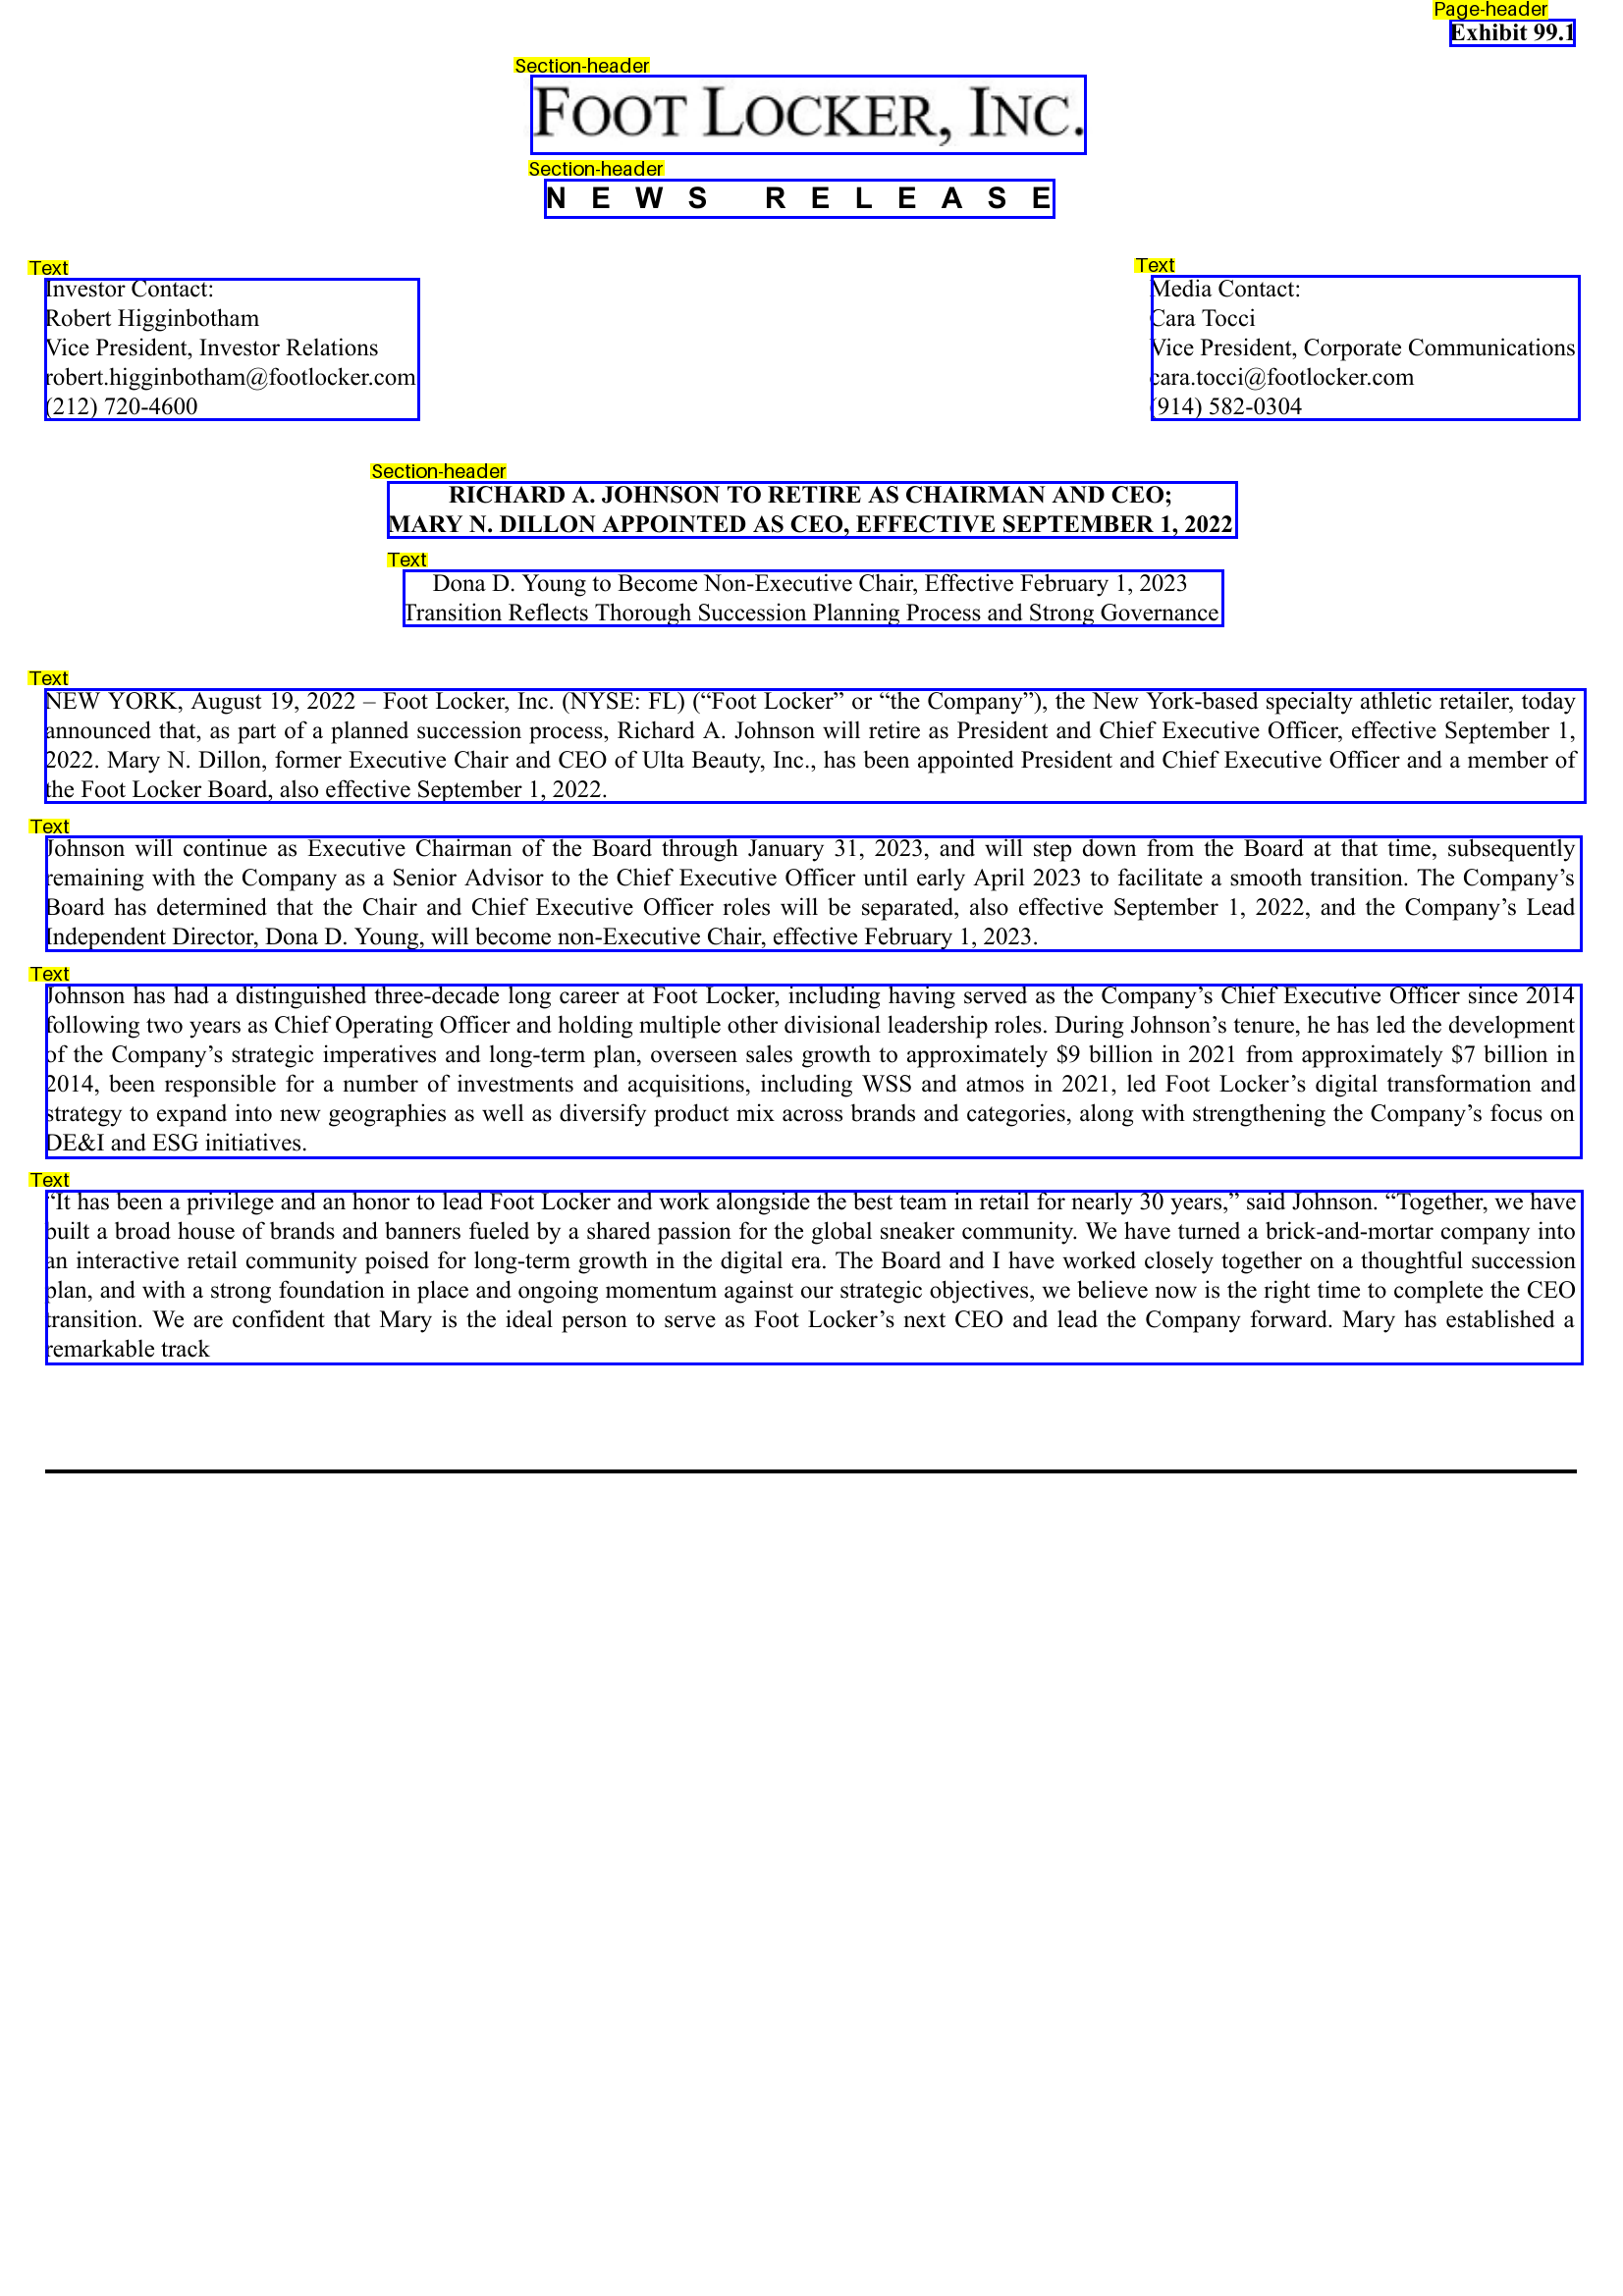

In [ ]:
# Page with text, Foot Locker 8K
partition_visualize("/app/work/docker_volume/visualize_pdfs/footlocker_text.pdf", False)

2024-06-12 19:36:46,771	INFO streaming_executor.py:115 -- Starting execution of Dataset. Full log is in /tmp/ray/session_2024-06-12_16-21-46_510622_17252/logs/ray-data.log
2024-06-12 19:36:46,772	INFO streaming_executor.py:116 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadBinary] -> TaskPoolMapOperator[Map(BinaryScan._to_document)->MapBatches(_wrap)->MapBatches(split_and_convert_to_image)] -> LimitOperator[limit=1] -> TaskPoolMapOperator[MapBatches(DrawBoxes)] -> LimitOperator[limit=1]



- ReadBinary->SplitBlocks(20) 1:   0%|          | 0/1 [00:00<?, ?it/s]

- Map(BinaryScan._to_document)->MapBatches(_wrap)->MapBatches(split_and_convert_to_image) 2:   0%|          | …

- limit=1 3:   0%|          | 0/1 [00:00<?, ?it/s]

- MapBatches(DrawBoxes) 4:   0%|          | 0/1 [00:00<?, ?it/s]

- limit=1 5:   0%|          | 0/1 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

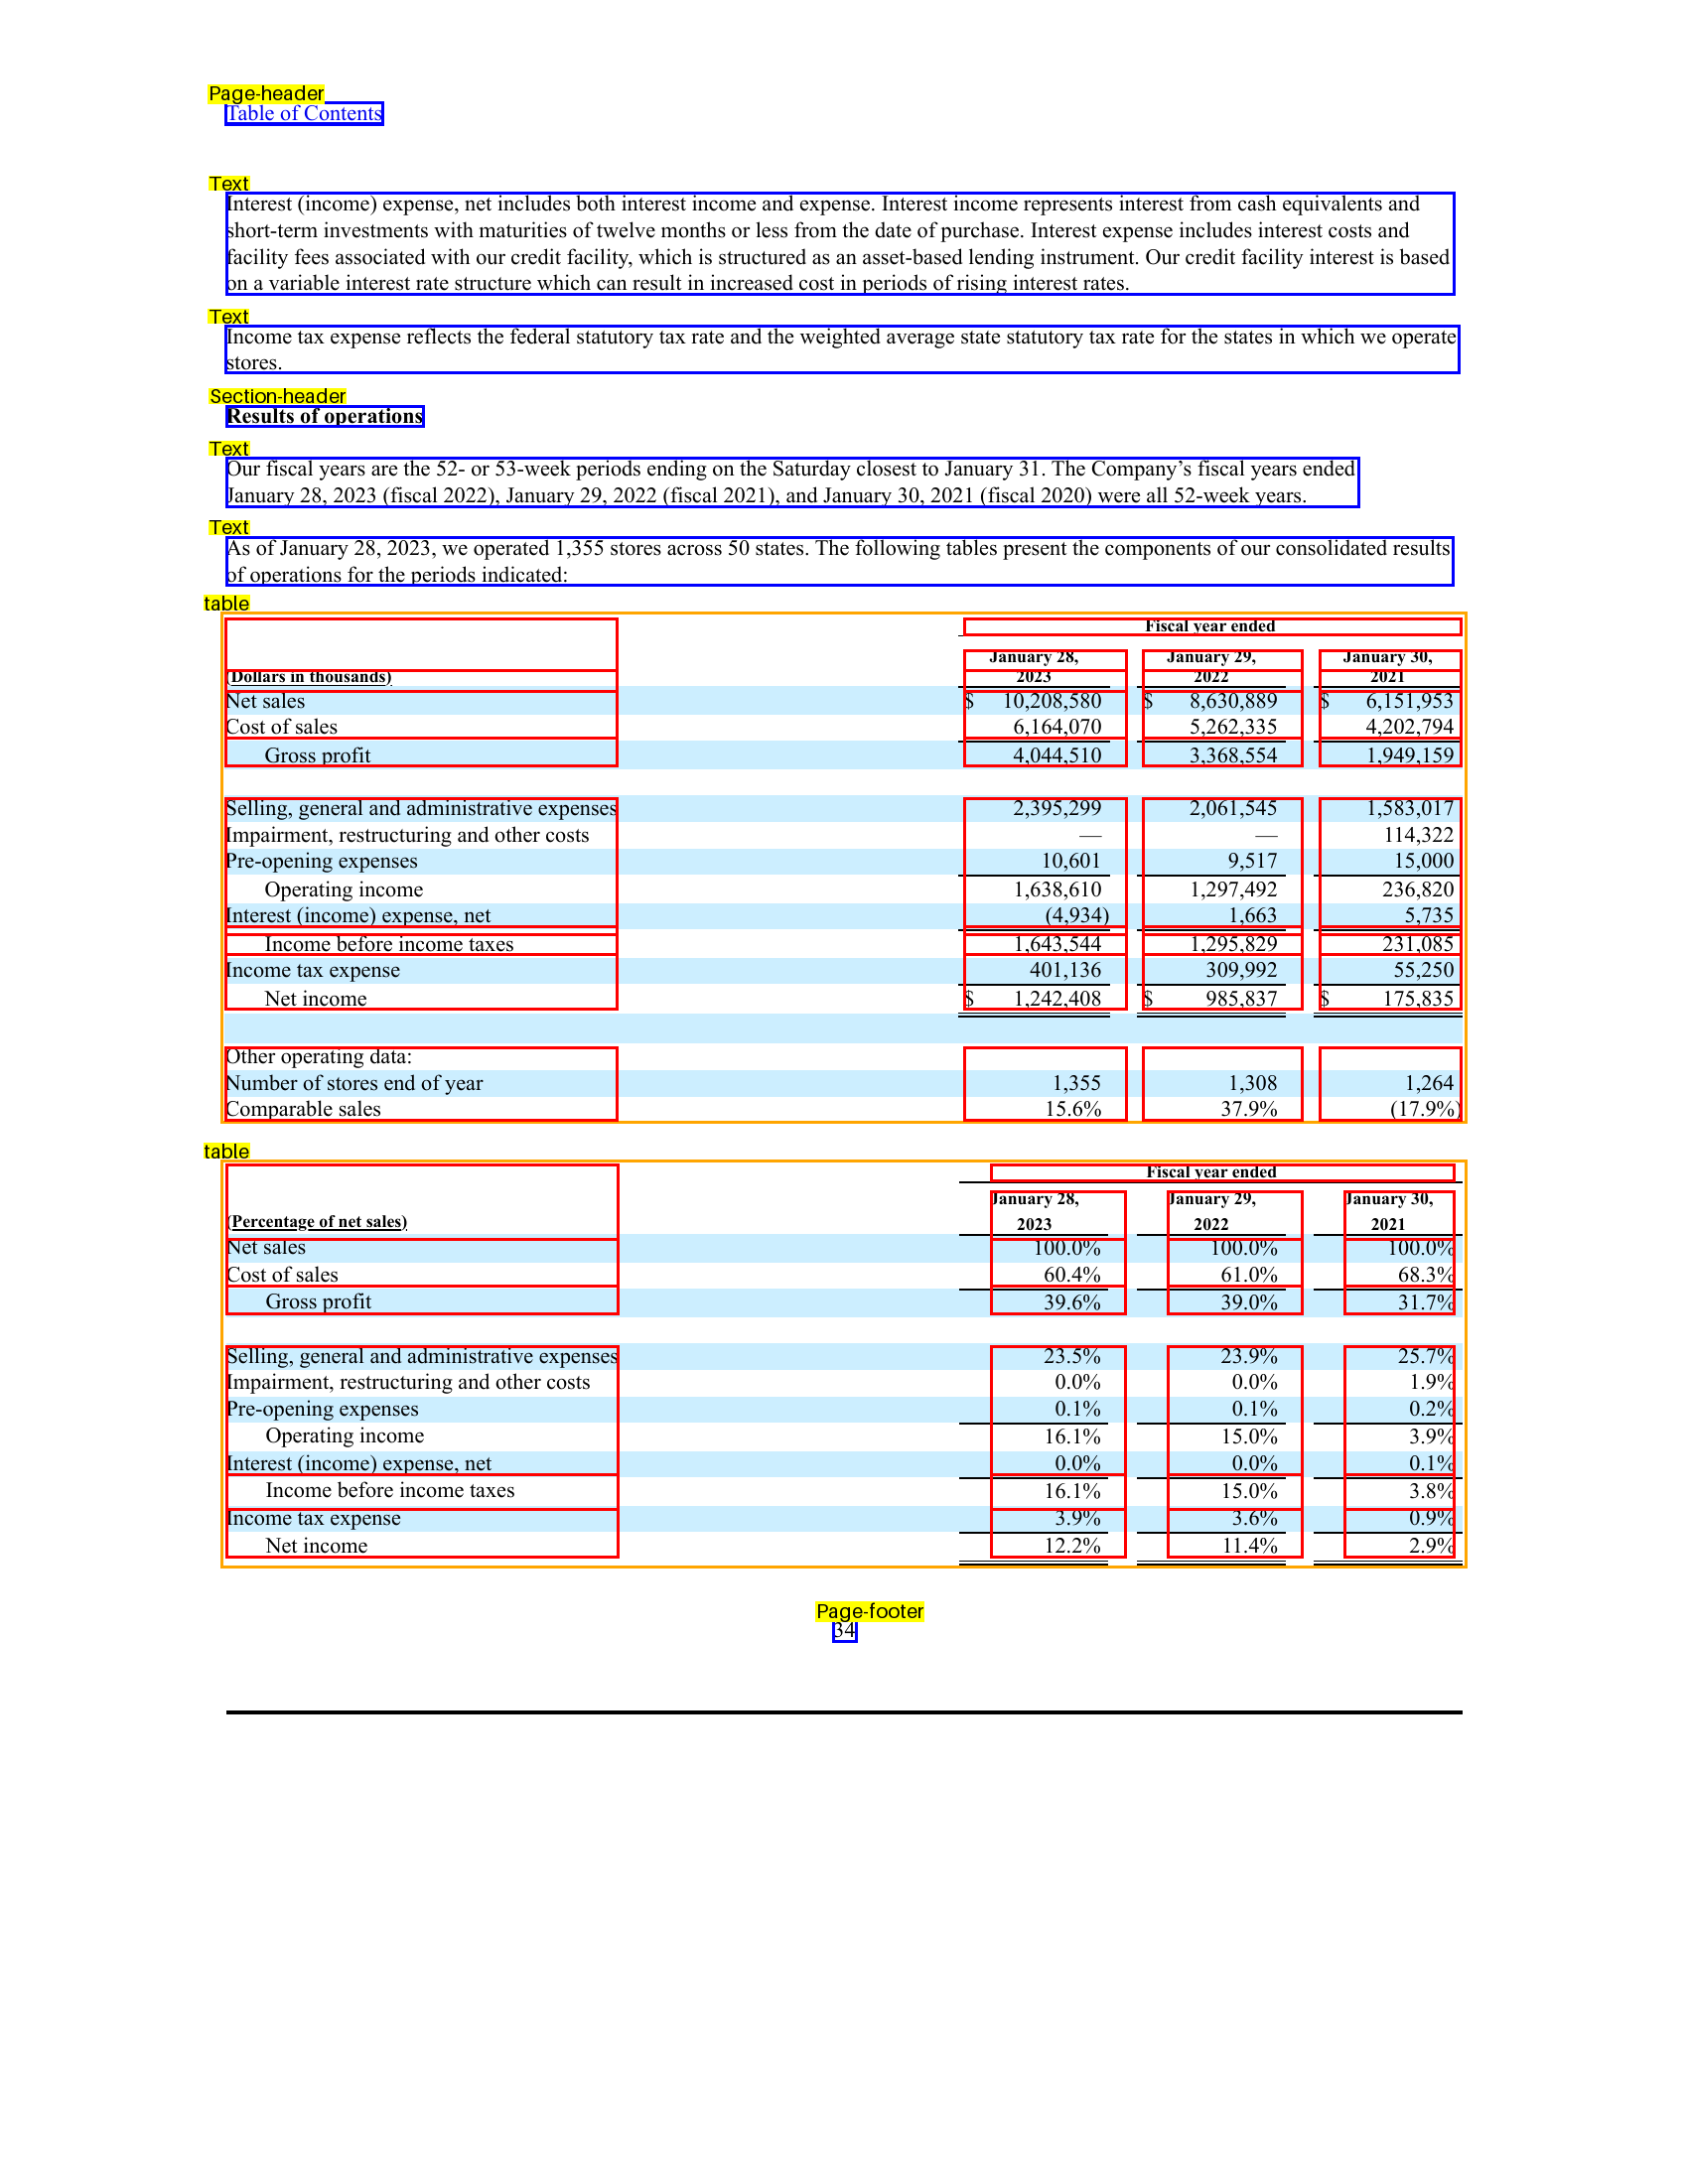

In [ ]:
# Page with text and table, Foot Locker 8K
partition_visualize("/app/work/docker_volume/visualize_pdfs/ultabeauty_table.pdf", True)

In [ ]:
def textract_partition_visualize(paths, thrshld=0.3):
    if len(paths) == 0:
        print("WARNING: import_pdf called with empty paths")
    
    if (
        (isinstance(paths, str) or isinstance(paths, Path)) 
        and Path(paths).exists() and Path(paths).is_dir()
        and len(list(Path(paths).iterdir())) == 0
    ):
        print("WARNING: import_pdf called with empty directory")
    
    ctx = sycamore.init()
    pdf_docset = ctx.read.binary(paths, binary_format="pdf", filter_paths_by_extension=False)
    # partitioned_docset = pdf_docset.partition(partitioner=SycamorePartitioner(threshold=thrshld), table_extractor=TextractTableExtractor(profile_name="AdministratorAccess-237550789389", region_name="us-east-1", s3_upload_root="s3://aanya-textract"), compute=ActorPoolStrategy(size=1))
    
    # show_pages(partitioned_docset, limit=1)
    doc = pdf_docset.take(1)[0]
    table_extractor=TextractTableExtractor(profile_name="AdministratorAccess-237550789389", region_name="us-east-1", s3_upload_root="s3://aanya-textract")
    textract_result = table_extractor.get_textract_result(doc)
    # tables = table_extractor.get_tables_from_textract_result(textract_result)
    for table in textract_result.tables:
        table.to_excel("/home/admin/sycamore/examples/visualize_pdfs/test.xlsx")

In [ ]:
textract_partition_visualize("/home/admin/sycamore/examples/visualize_pdfs/3m_1.pdf", 0.35)

2024-07-09 19:38:45,261	INFO streaming_executor.py:112 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-07-09_16-32-36_503269_2681/logs/ray-data
2024-07-09 19:38:45,261	INFO streaming_executor.py:113 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadBinary] -> TaskPoolMapOperator[Map(BinaryScan._to_document)]


- ReadBinary->SplitBlocks(16) 1:   0%|          | 0/1 [00:00<?, ?it/s]

- Map(BinaryScan._to_document) 2:   0%|          | 0/1 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
def ocr_partition_visualize(paths, thrshld=0.3):
    if len(paths) == 0:
        print("WARNING: import_pdf called with empty paths")
    
    if (
        (isinstance(paths, str) or isinstance(paths, Path)) 
        and Path(paths).exists() and Path(paths).is_dir()
        and len(list(Path(paths).iterdir())) == 0
    ):
        print("WARNING: import_pdf called with empty directory")
    
    ctx = sycamore.init()
    pdf_docset = ctx.read.binary(paths, binary_format="pdf", filter_paths_by_extension=False)
    partitioned_docset = pdf_docset.partition(partitioner=SycamorePartitioner(use_ocr=True, extract_table_structure=True, threshold=thrshld), compute=ActorPoolStrategy(size=1))
    
    show_pages(partitioned_docset, limit=1)

AAAAAAAAA


2024-07-09 23:02:05,850	WARNING util.py:560 -- The argument ``compute`` is deprecated in Ray 2.9. Please specify argument ``concurrency`` instead. For more information, see https://docs.ray.io/en/master/data/transforming-data.html#stateful-transforms.
2024-07-09 23:02:05,856	INFO streaming_executor.py:112 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-07-09_22-50-51_443332_98404/logs/ray-data
2024-07-09 23:02:05,856	INFO streaming_executor.py:113 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadBinary] -> TaskPoolMapOperator[Map(BinaryScan._to_document)] -> ActorPoolMapOperator[MapBatches(BaseMapTransformCallable___wrap)] -> TaskPoolMapOperator[MapBatches(split_and_convert_to_image)] -> LimitOperator[limit=1] -> TaskPoolMapOperator[MapBatches(DrawBoxes)]


- ReadBinary->SplitBlocks(16) 1:   0%|          | 0/1 [00:00<?, ?it/s]

- Map(BinaryScan._to_document) 2:   0%|          | 0/1 [00:00<?, ?it/s]

- MapBatches(BaseMapTransformCallable___wrap) 3:   0%|          | 0/1 [00:00<?, ?it/s]

- MapBatches(split_and_convert_to_image) 4:   0%|          | 0/1 [00:00<?, ?it/s]

- limit=1 5:   0%|          | 0/1 [00:00<?, ?it/s]

- MapBatches(DrawBoxes) 6:   0%|          | 0/1 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

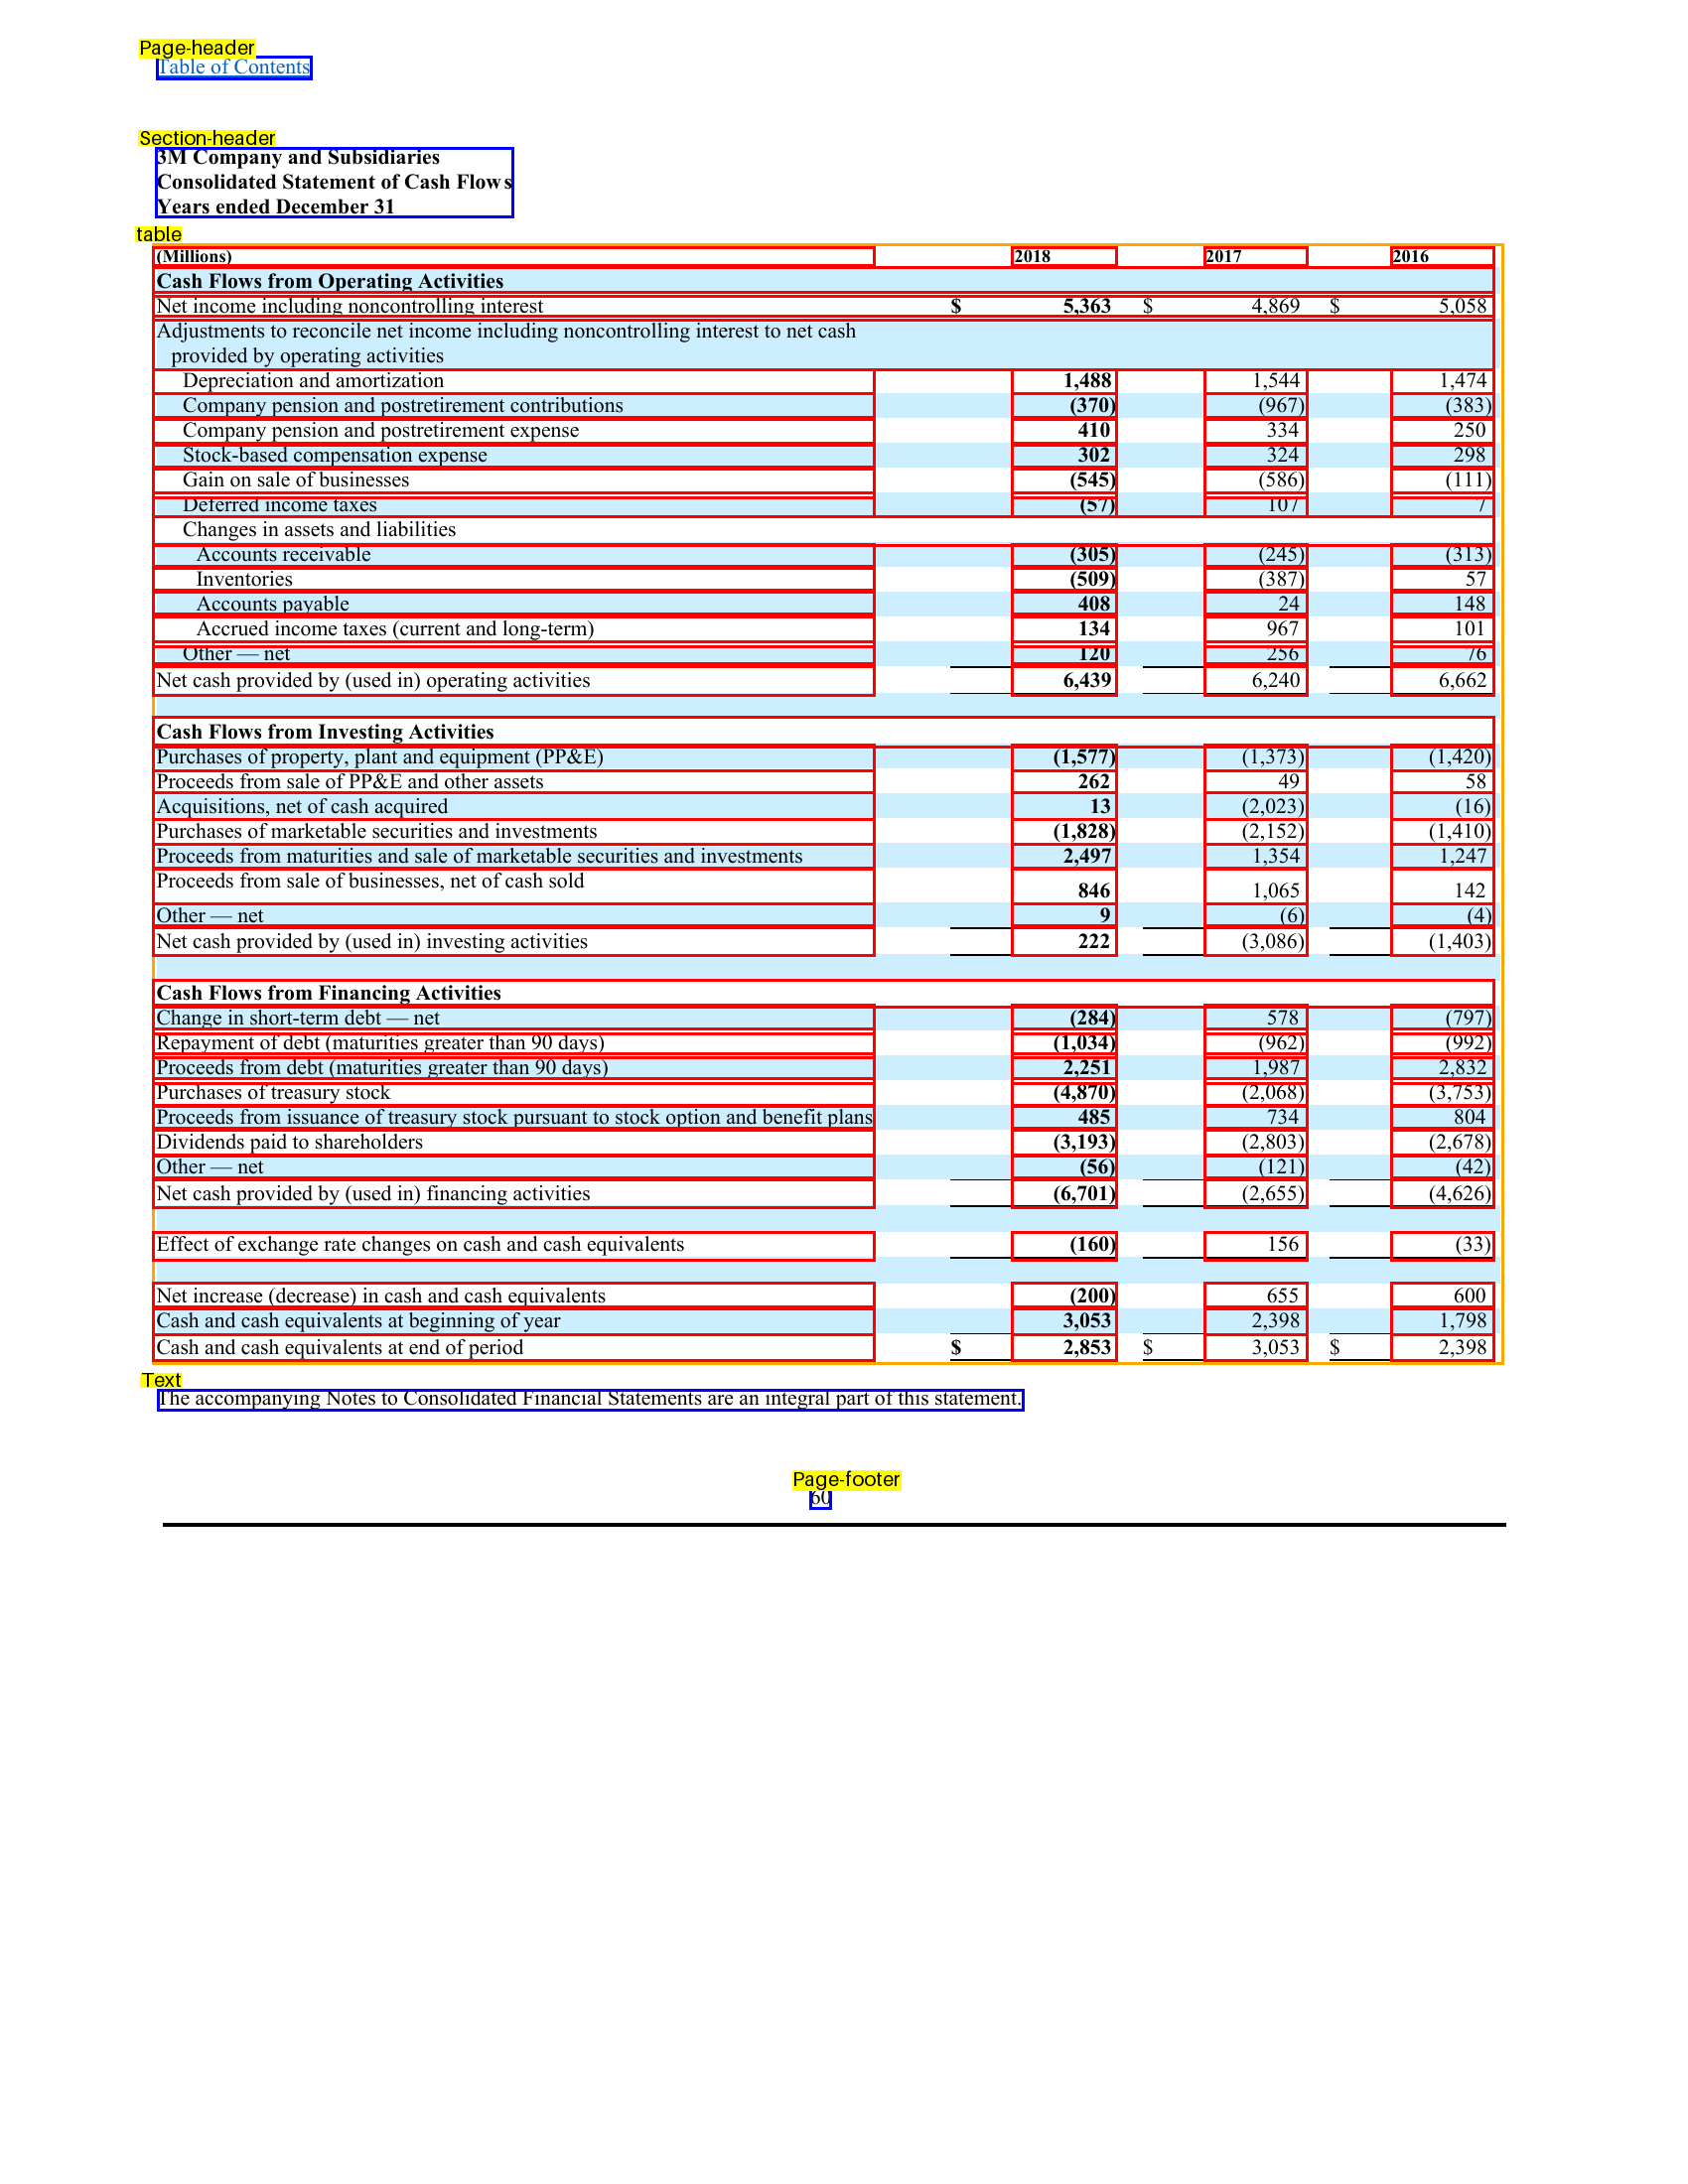

In [ ]:
ocr_partition_visualize("/home/admin/sycamore/examples/visualize_pdfs/3m_1.pdf", 0.35)